## Data Prep

In [2]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import itertools
from math import sqrt

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
train = pd.read_csv('train.csv', index_col=0, parse_dates=[0])
test = pd.read_csv('test.csv', index_col=0, parse_dates=[0])
train.head()

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_66478/1969119848.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train = pd.read_csv('train.csv', index_col=0, parse_dates=[0])
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_66478/1969119848.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train = pd.read_csv('train.csv', index_col=0, parse_dates=[0])
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_66478/1969119848.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test = pd.read_csv('test.csv', index_col=0, parse_dates=[0])
/var/fold

date location  new_cases  new_deaths  reproduction_rate  new_tests  \
0  2020-03-21  Belgium      713.0        35.0               2.16     2276.0   
1  2020-03-22  Belgium      662.0        40.0               2.13     1414.0   
2  2020-03-23  Belgium      469.0        41.0               2.09     3322.0   
3  2020-03-24  Belgium      486.0        55.0               2.05     3975.0   
4  2020-03-25  Belgium     1328.0        81.0               2.01     4282.0   

   stringency_index  population_density  aged_70_older  diabetes_prevalence  \
0             81.48             375.564         12.849                 4.29   
1             81.48             375.564         12.849                 4.29   
2             81.48             375.564         12.849                 4.29   
3             81.48             375.564         12.849                 4.29   
4             81.48             375.564         12.849                 4.29   

   ...  dayofyear  dayofmonth  weekofyear  new_cases_lag1  new_cases_lag7  \
0  ...         81          21          12             0.0             0.0   
1  ...         82          22          12           713.0             0.0   
2  ...         83          23          13           662.0             0.0   
3  ...         84          24          13           469.0             0.0   
4  ...         85          25          13           486.0             0.0   

  new_cases_lag8  new_cases_roll_mean7  new_cases_roll_std7  \
0            0.0                   0.0                  0.0   
1            0.0                   0.0                  0.0   
2            0.0                   0.0                  0.0   
3            0.0                   0.0                  0.0   
4            0.0                   0.0                  0.0   

   new_cases_roll_mean14  new_cases_roll_std14  
0                    0.0                   0.0  
1                    0.0                   0.0  
2                    0.0                   0.0  
3                    0.0                   0.0  
4                    0.0                   0.0  

[5 rows x 31 columns]

In [12]:
# only use date and new_cases
train = train[['date', 'new_cases','location']]
train.set_index('date', inplace=True)
train.index = pd.to_datetime(train.index)

test = test[['date', 'new_cases','location']]
test.set_index('date', inplace=True)
test.index = pd.to_datetime(test.index)

train.head()

new_cases location
date                          
2020-03-21      713.0  Belgium
2020-03-22      662.0  Belgium
2020-03-23      469.0  Belgium
2020-03-24      486.0  Belgium
2020-03-25     1328.0  Belgium

In [13]:
# ARIMA is senstive to missing values
missing_count = train['new_cases'].isna().sum()
print(f"Count of missing values: {missing_count}")

Count of missing values: 0


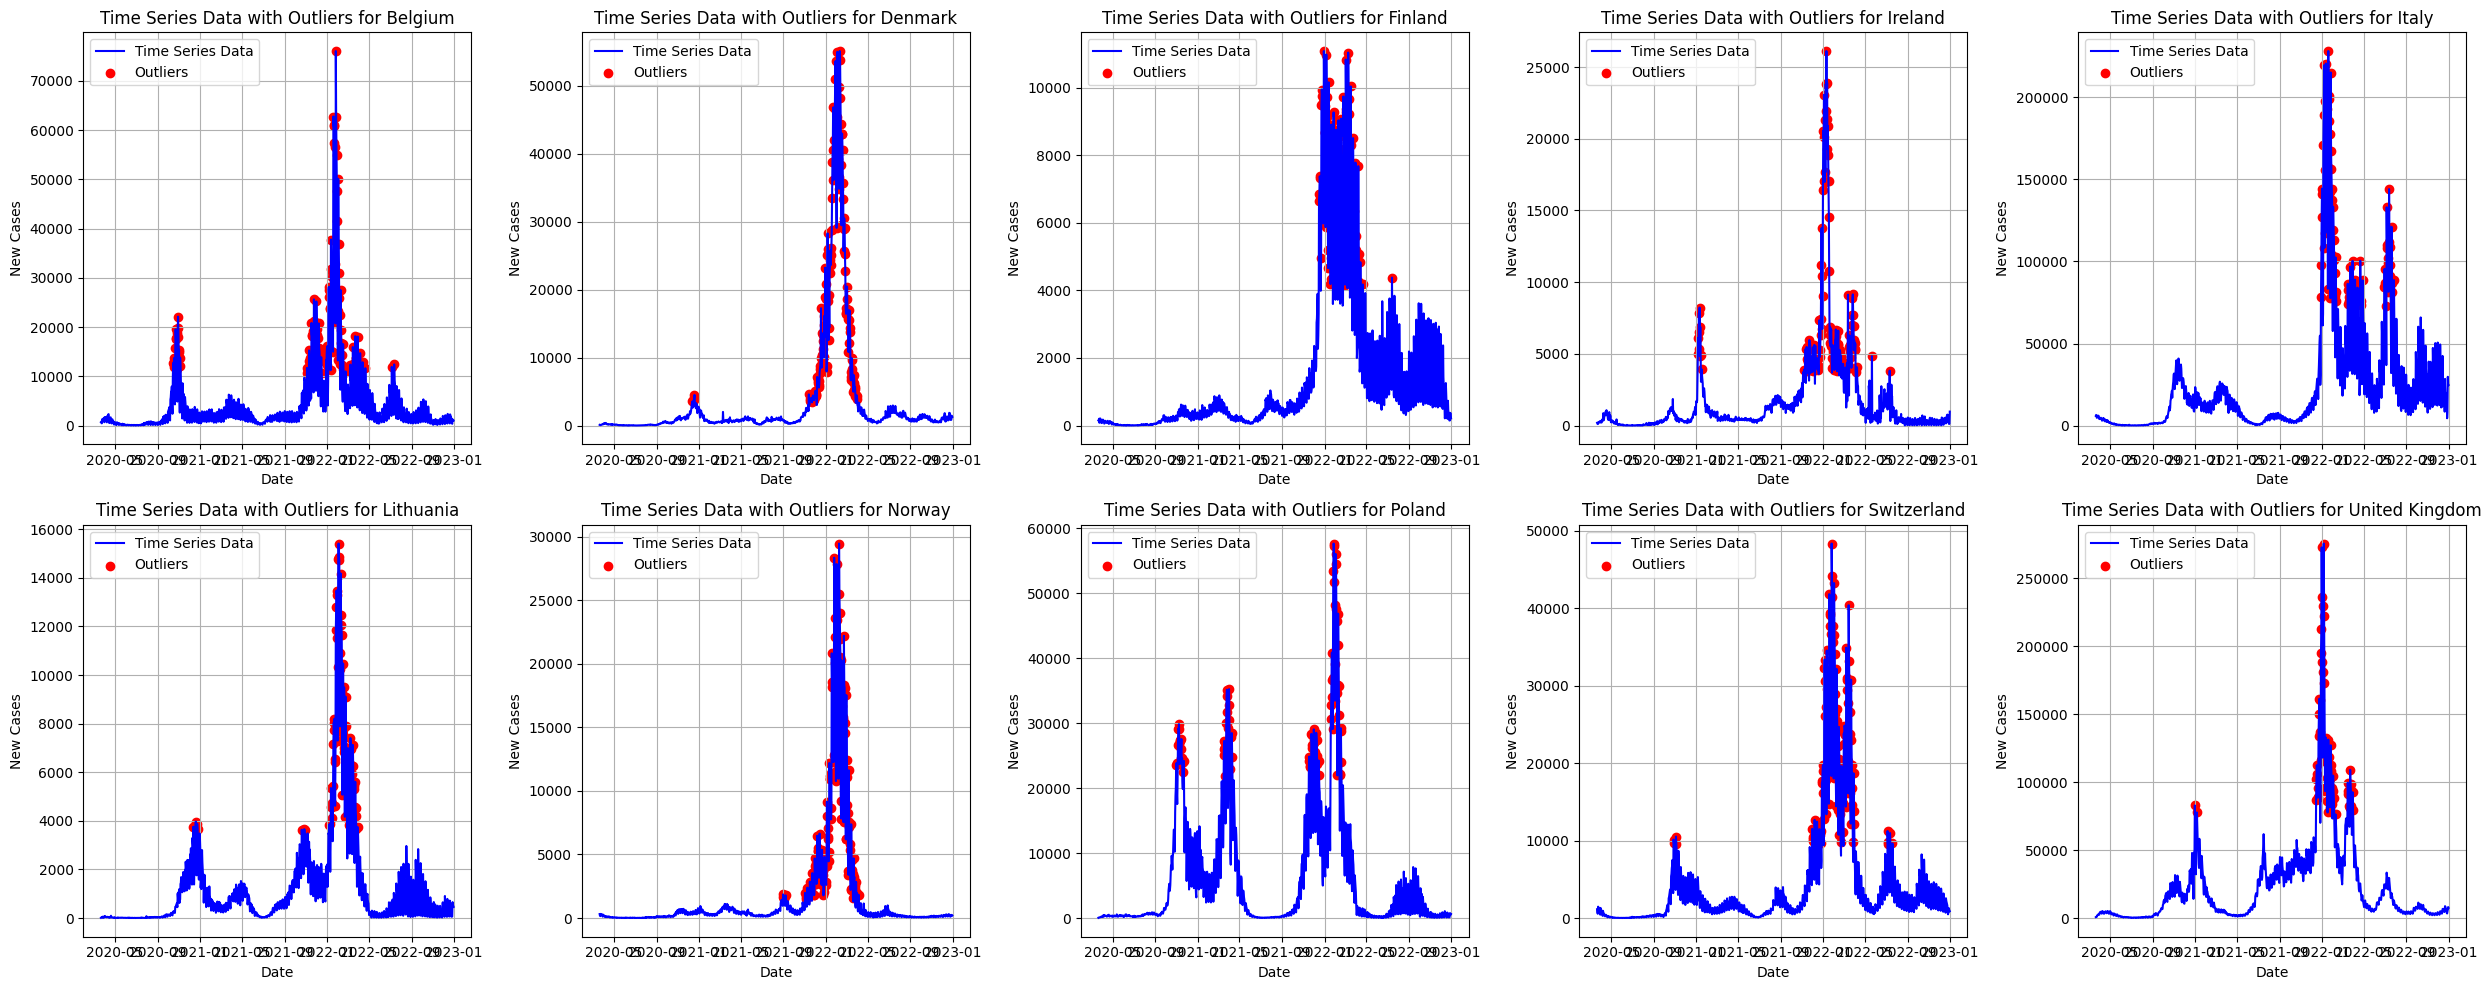

In [14]:
# ARIMA is sensitive to outliers
locations = train['location'].unique()

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
axes = axes.flatten()

for i, location in enumerate(locations):
    ax = axes[i]
    location_data = train[train['location'] == location]
    Q1 = location_data['new_cases'].quantile(0.25)
    Q3 = location_data['new_cases'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = location_data[(location_data['new_cases'] < lower_bound) | (location_data['new_cases'] > upper_bound)]

    ax.plot(location_data.index, location_data['new_cases'], label='Time Series Data', color='blue')
    ax.scatter(outliers.index, outliers['new_cases'], color='red', label='Outliers')
    ax.set_title(f'Time Series Data with Outliers for {location}')
    ax.set_xlabel('Date')
    ax.set_ylabel('New Cases')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# cap the outliers at upper_bound to minimize impact of peaks
for location in locations:
    location_data = train[train['location'] == location]
    Q1 = location_data['new_cases'].quantile(0.25)
    Q3 = location_data['new_cases'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    train.loc[train['location'] == location, 'new_cases'] = train.loc[train['location'] == location, 'new_cases'].apply(lambda x: upper_bound if x > upper_bound else x)


In [44]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller

for country in train['location'].unique():
    country_data = train[train['location'] == country]
    result = adfuller(country_data['new_cases'].values)
    
    print(f'Results for {country}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('---------------------------------------------')

Results for Belgium:
ADF Statistic: -2.645138
p-value: 0.084022
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Denmark:
ADF Statistic: -2.731998
p-value: 0.068663
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Finland:
ADF Statistic: -2.057258
p-value: 0.262045
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Ireland:
ADF Statistic: -2.536493
p-value: 0.106846
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Italy:
ADF Statistic: -2.452391
p-value: 0.127492
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Lithuania:
ADF Statistic: -2.887949
p-value: 0.046767
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Norw

Countries with stationary data (p<0.05) include Lithunia and Poland. Belgium, Denmark, Finland, Ireland, Italy, Norway, Switzerland, and United Kingdom have non-stationary data and need to be differenced the series until it is stationary.

In [45]:
location_stationary = ['Lithunia', 'Poland']
location_nonstationary = ['Belgium', 'Denmark', 'Finland', 'Ireland', 'Italy', 
                           'Norway', 'Switzerland', 'United Kingdom']

train_stationary = train[train['location'].isin(location_stationary)]
train_nonstationary = train[train['location'].isin(location_nonstationary)]

train_nonstationary_diff = pd.DataFrame()

for country in location_nonstationary:
    country_data = train_nonstationary[train_nonstationary['location'] == country]
    country_data['new_cases_differenced'] = country_data['new_cases'].diff(1)
    train_nonstationary_diff = pd.concat([train_nonstationary_diff, country_data])

train_nonstationary_diff.head(5)

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_15788/1053011549.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['new_cases_differenced'] = country_data['new_cases'].diff(1)
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_15788/1053011549.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['new_cases_differenced'] = country_data['new_cases'].diff(1)
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_15788/1053011549.py:12: SettingWithCopyWarning:

new_cases location  new_cases_differenced
date                                                 
2020-03-21      713.0  Belgium                    NaN
2020-03-22      662.0  Belgium                  -51.0
2020-03-23      469.0  Belgium                 -193.0
2020-03-24      486.0  Belgium                   17.0
2020-03-25     1328.0  Belgium                  842.0

In [47]:
train_nonstationary_diff = train_nonstationary_diff.fillna(0)
for country in train_nonstationary_diff['location'].unique():
    country_data = train_nonstationary_diff[train_nonstationary_diff['location'] == country]
    result = adfuller(country_data['new_cases_differenced'].values)
    print(f'Results for {country}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('---------------------------------------------')

Results for Belgium:
ADF Statistic: -6.678740
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Denmark:
ADF Statistic: -5.945897
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Finland:
ADF Statistic: -5.348565
p-value: 0.000004
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Ireland:
ADF Statistic: -7.557164
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Italy:
ADF Statistic: -7.193492
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Norway:
ADF Statistic: -6.155380
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
---------------------------------------------
Results for Switzer

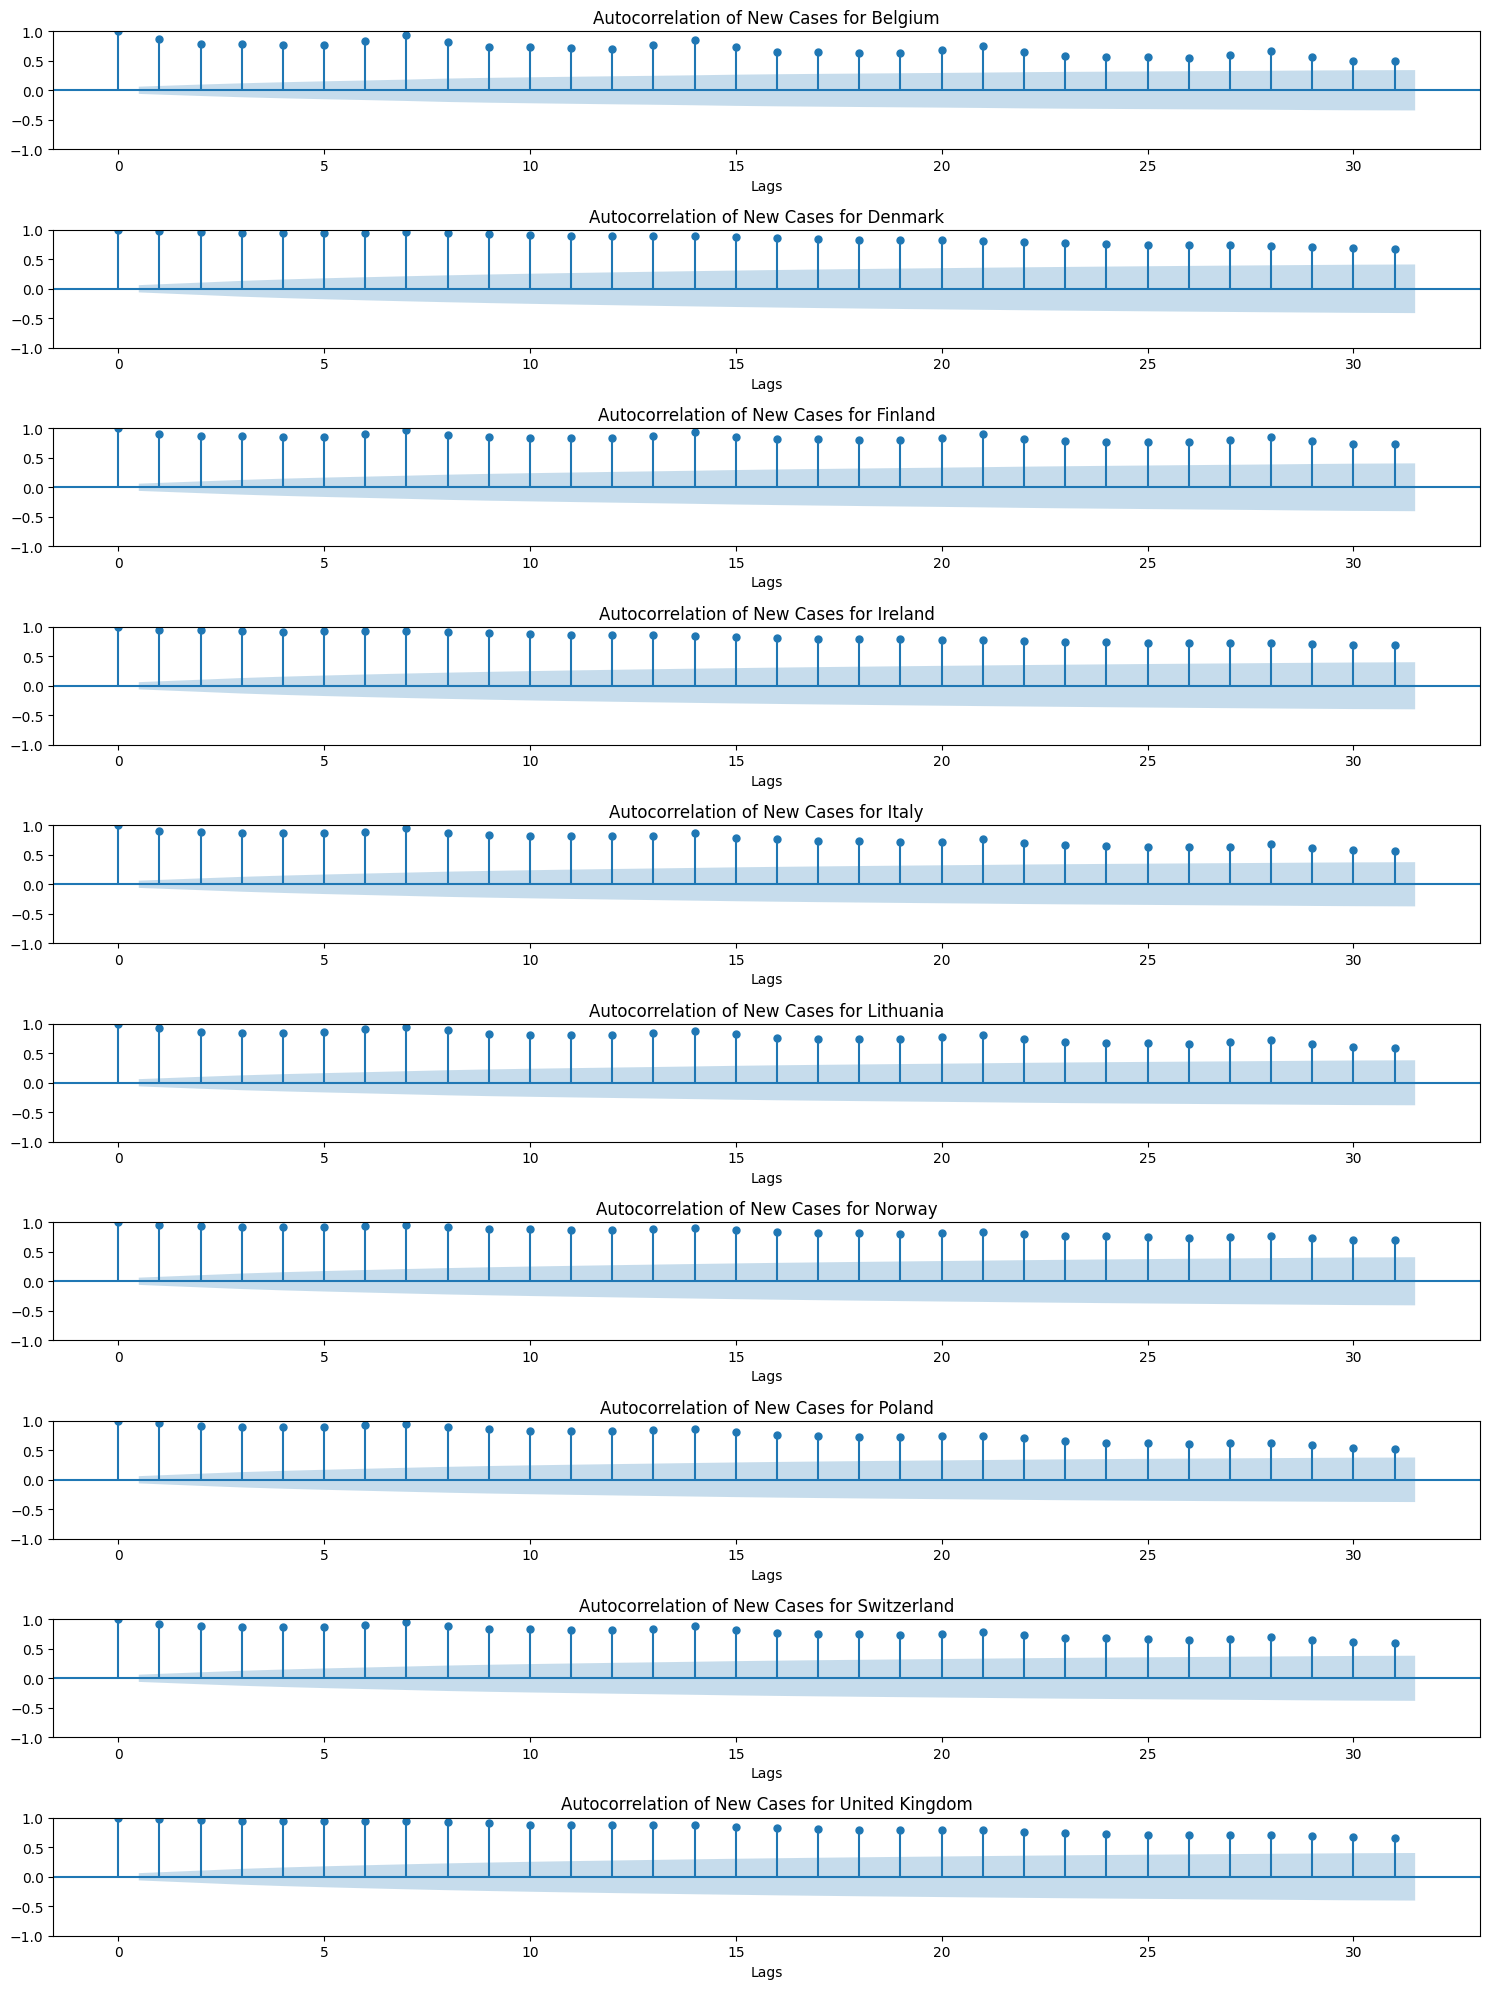

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt

countries = train['location'].unique()

plt.figure(figsize=(15, 20))

for i, country in enumerate(countries, 1):
    plt.subplot(len(countries), 1, i)
    country_data = train[train['location'] == country]['new_cases']
    plot_acf(country_data.dropna(), alpha=0.05, ax=plt.gca())
    plt.title(f'Autocorrelation of New Cases for {country}')
    plt.xlabel('Lags')

plt.tight_layout()
plt.show()

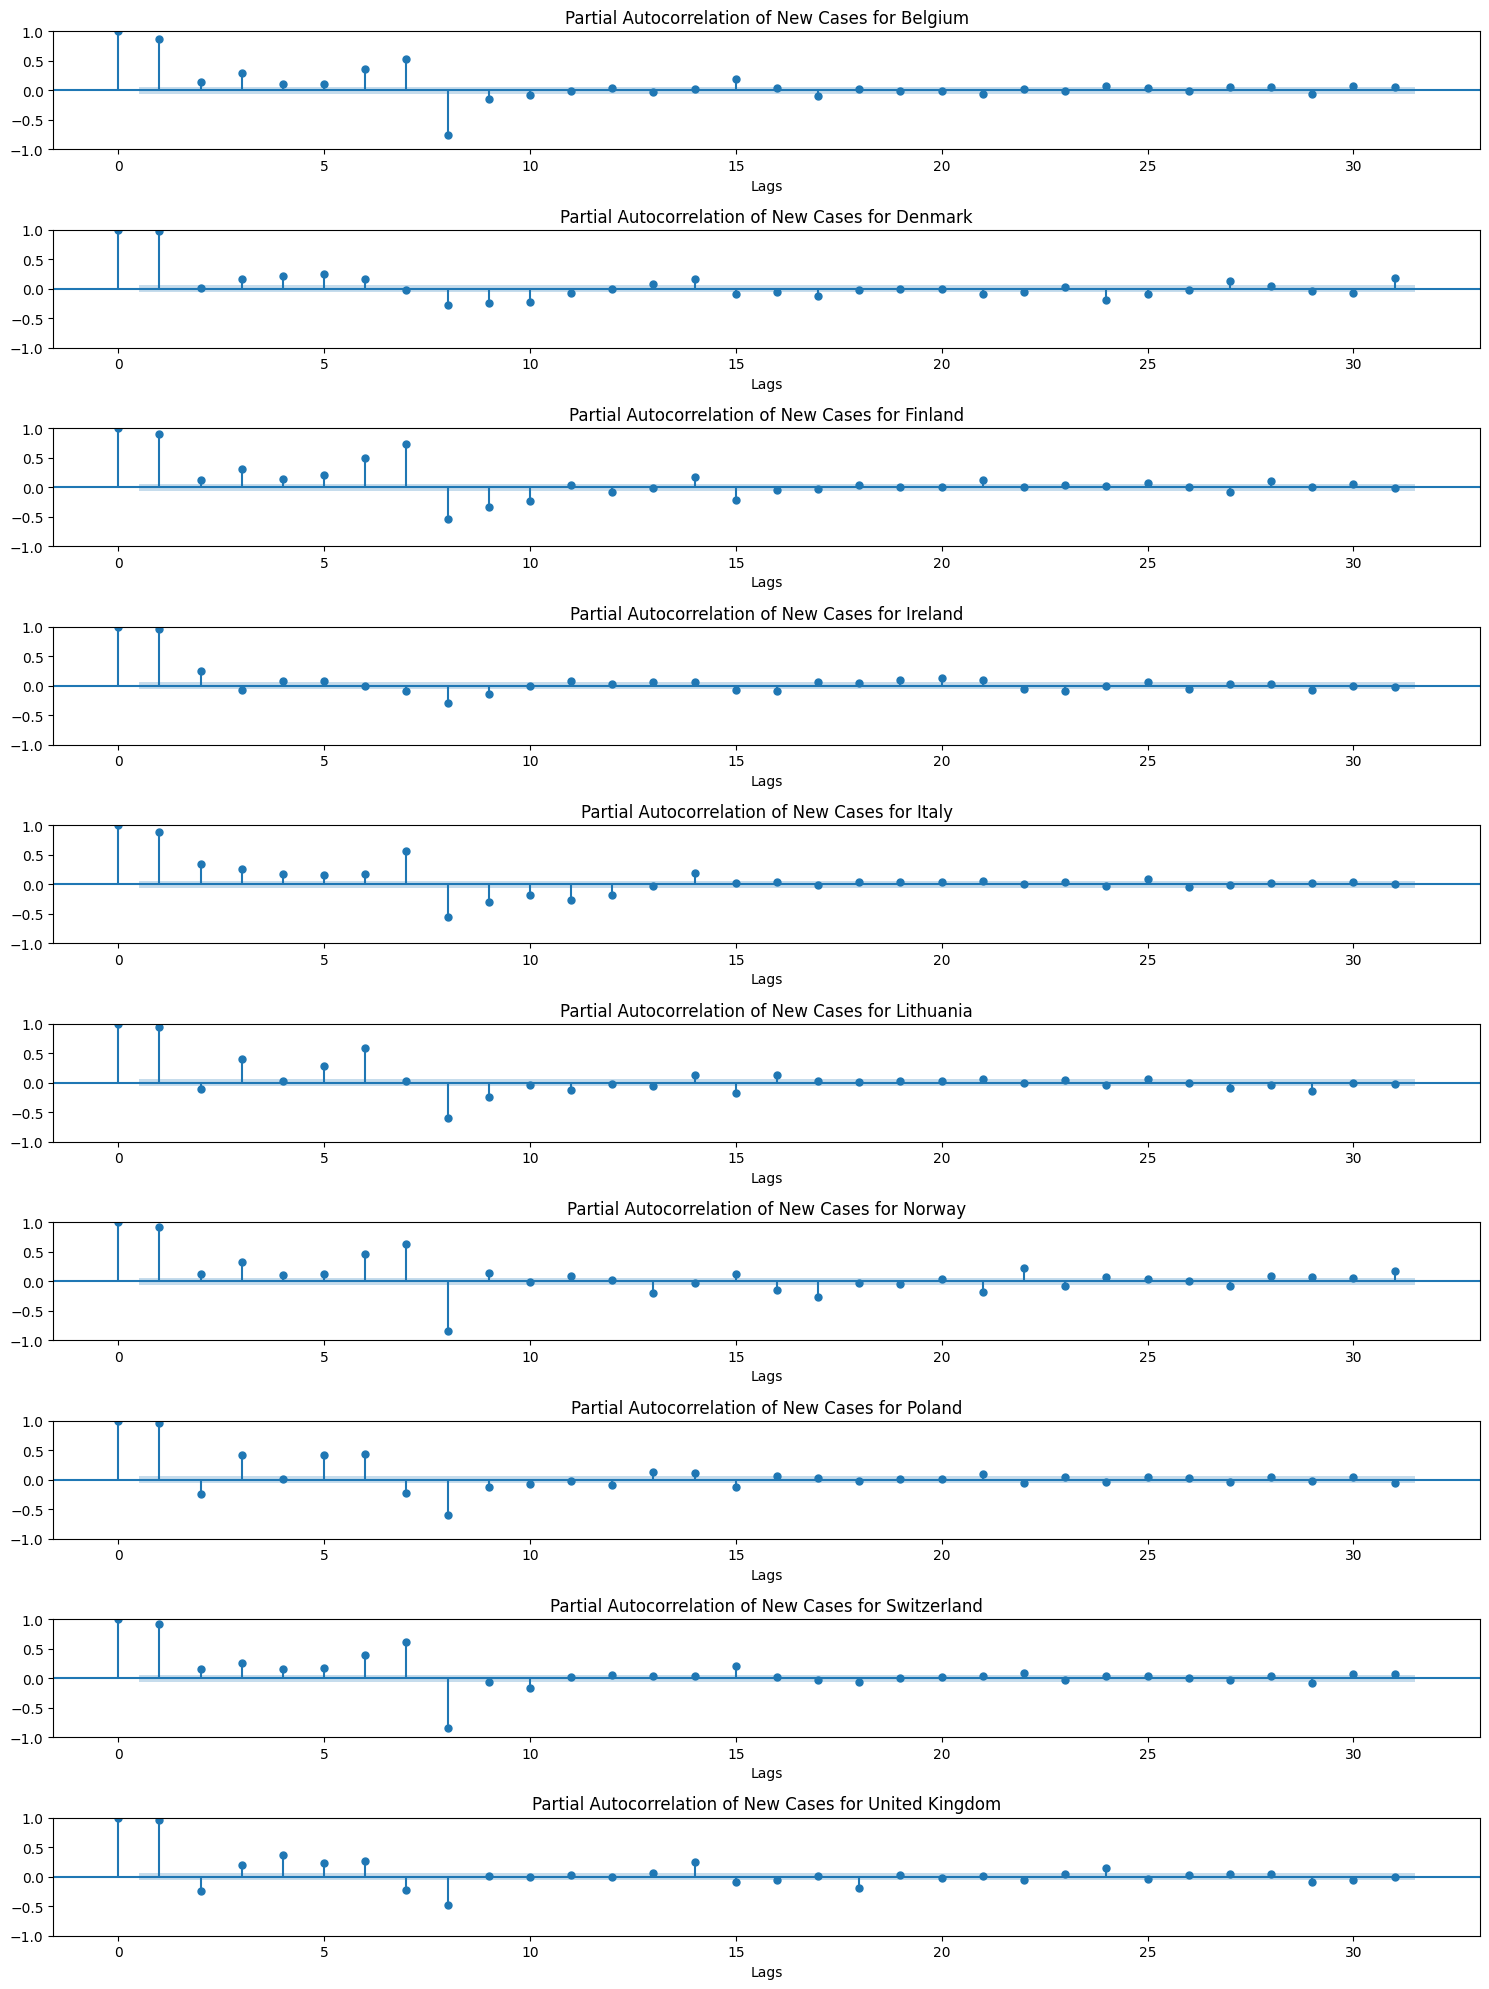

In [41]:
#pacf
plt.figure(figsize=(15, 20))

for i, country in enumerate(countries, 1):
    plt.subplot(len(countries), 1, i)
    country_data = train[train['location'] == country]['new_cases']
    plot_pacf(country_data.dropna(), alpha=0.05, ax=plt.gca())
    plt.title(f'Partial Autocorrelation of New Cases for {country}')
    plt.xlabel('Lags')

plt.tight_layout()
plt.show()

The ACF shows a gradual decline, indicating a higher order of autoregression. We observe significant correlations at the first few lags, followed by correlations that are not significant.	This indicates an autoregressive term in the data. I will start with 4 for the order of the autoregressive term.

In [12]:
# # same for test
# test_stationary = test[test['location'].isin(location_stationary)]
# test_nonstationary = test[test['location'].isin(location_nonstationary)]

# test_nonstationary_diff = pd.DataFrame()

# for country in location_nonstationary:
#     country_data = test_nonstationary[test_nonstationary['location'] == country]
#     country_data['new_cases_differenced'] = country_data['new_cases'].diff(1)
#     test_nonstationary_diff = pd.concat([test_nonstationary_diff, country_data])

# test_nonstationary_diff.head()

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_15788/823558819.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['new_cases_differenced'] = country_data['new_cases'].diff(1)
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_15788/823558819.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['new_cases_differenced'] = country_data['new_cases'].diff(1)
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_15788/823558819.py:9: SettingWithCopyWarning: 
A va

new_cases location  new_cases_differenced
date                                                 
2023-01-01      943.0  Belgium                    NaN
2023-01-02      396.0  Belgium                 -547.0
2023-01-03      224.0  Belgium                 -172.0
2023-01-04     1119.0  Belgium                  895.0
2023-01-05      842.0  Belgium                 -277.0

In [8]:
## define a function to get data for individual countries
def get_country_data(country, train, test):
    train_country = train[train['location'] == country]['new_cases']
    test_country = test[test['location'] == country]['new_cases']
    return train_country, test_country

# Non-Stationary

## ARIMA

In [72]:
train_italy, test_italy = get_country_data('Italy', train, test)
train_italy.shape

(1016,)

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train RMSE: 6715.849476466177
Test RMSE: 9813.377705564164


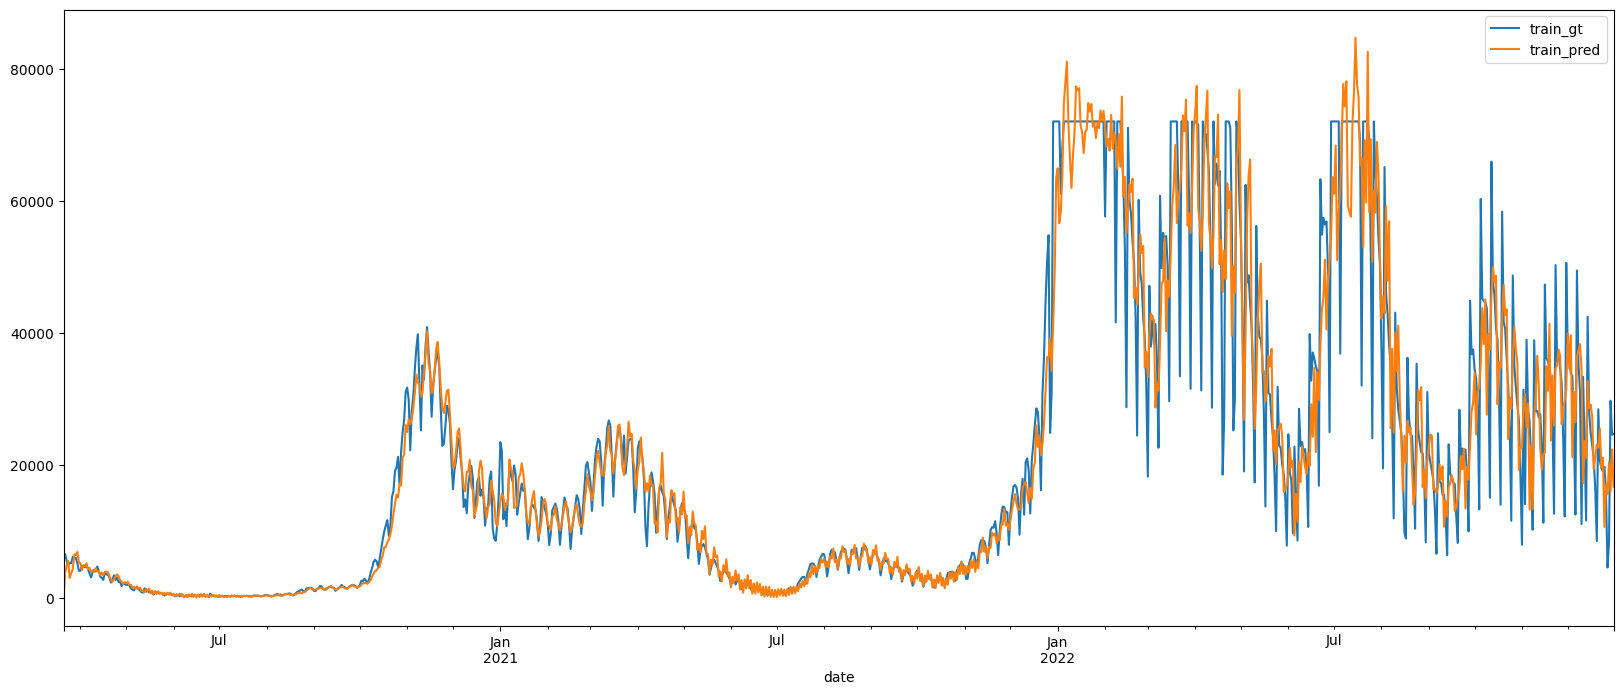

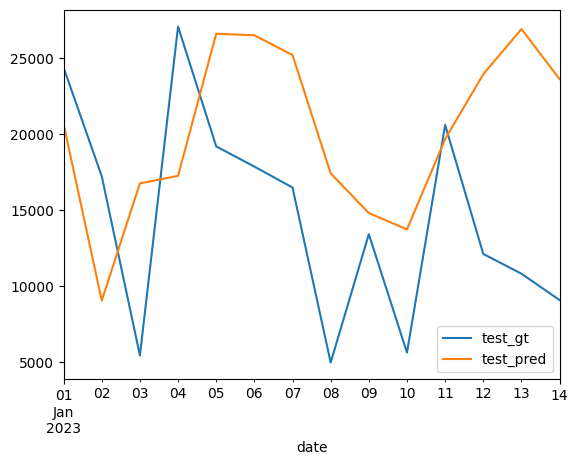

In [58]:
model1_italy = ARIMA(train_italy, order=(5, 1, 3))
model1_italy = model1_italy.fit()
train_pred=model1_italy.fittedvalues
pd.concat([train_italy, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

#test
test_pred = model1_italy.predict(start=len(train_italy), end=len(train_italy)+len(test_italy)-1, dynamic=True)
test_pred.index = test_italy.index
pd.concat([test_italy, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

italy_train_rmse = np.sqrt(mean_squared_error(train_italy, train_pred))
italy_test_rmse = np.sqrt(mean_squared_error(test_italy, test_pred))

print(f'Train RMSE: {italy_train_rmse}')
print(f'Test RMSE: {italy_test_rmse}')

#### Grid Search

In [60]:
p = q = range(0, 6)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
best_score, best_cfg = float("inf"), None

for param in pdq:
    try:
        model = ARIMA(train_italy, order=param)
        model = model.fit()
        train_poland_pred=model.fittedvalues
        error = sqrt(mean_squared_error(train_italy, train_poland_pred))
        if error < best_score:
            best_score, best_cfg = error, param
        print('ARIMA{} - RMSE:{}'.format(param, error))
    except:
        continue

print('Best ARIMA{} RMSE={}'.format(best_cfg, best_score))

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(0, 0, 0) - RMSE:22122.824126048945
ARIMA(0, 0, 1) - RMSE:14615.179486969335
ARIMA(0, 0, 2) - RMSE:11758.224303878804


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(0, 0, 3) - RMSE:10370.748721852082
ARIMA(0, 0, 4) - RMSE:9229.920827162548
ARIMA(0, 0, 5) - RMSE:9085.689791915165
ARIMA(0, 1, 0) - RMSE:9508.730685973083
ARIMA(0, 1, 1) - RMSE:8111.067543173577
ARIMA(0, 1, 2) - RMSE:8054.665312100943


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(0, 1, 3) - RMSE:7796.93372590738
ARIMA(0, 1, 4) - RMSE:7042.050376329536


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(0, 1, 5) - RMSE:7121.892760557835
ARIMA(1, 0, 0) - RMSE:9295.665166641253


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(1, 0, 1) - RMSE:8108.1656237191855
ARIMA(1, 0, 2) - RMSE:8052.672648739434


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(1, 0, 3) - RMSE:9256.396944830924


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 4) - RMSE:7035.491579669951


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 5) - RMSE:7113.812794917299
ARIMA(1, 1, 0) - RMSE:8852.183303756774
ARIMA(1, 1, 1) - RMSE:8064.163025917582


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(1, 1, 2) - RMSE:7771.340268017265
ARIMA(1, 1, 3) - RMSE:7770.063830105516


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(1, 1, 4) - RMSE:7006.698015027518


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 5) - RMSE:6706.057020449023
ARIMA(2, 0, 0) - RMSE:8761.323949308318


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(2, 0, 1) - RMSE:8062.020033743206
ARIMA(2, 0, 2) - RMSE:7770.312728969871


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(2, 0, 3) - RMSE:7824.289729000938
ARIMA(2, 0, 4) - RMSE:7002.814781231549


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 5) - RMSE:6699.798777095613
ARIMA(2, 1, 0) - RMSE:8553.864880414096
ARIMA(2, 1, 1) - RMSE:8028.81071025923


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(2, 1, 2) - RMSE:7769.91327943153
ARIMA(2, 1, 3) - RMSE:7525.5380414413985


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(2, 1, 4) - RMSE:7004.647983289485


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 5) - RMSE:6523.97531217891
ARIMA(3, 0, 0) - RMSE:8505.227464649786


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(3, 0, 1) - RMSE:8027.292373527283


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(3, 0, 2) - RMSE:7769.021009785325


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(3, 0, 3) - RMSE:8121.34027077199
ARIMA(3, 0, 4) - RMSE:7001.371022400705


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(3, 0, 5) - RMSE:6524.277701862036
ARIMA(3, 1, 0) - RMSE:8377.011134199276
ARIMA(3, 1, 1) - RMSE:7966.936441436578
ARIMA(3, 1, 2) - RMSE:7141.001466044956


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 3) - RMSE:7511.050947055658


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 4) - RMSE:7264.786998598435


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 5) - RMSE:6337.72843395835
ARIMA(4, 0, 0) - RMSE:8348.619046410939


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(4, 0, 1) - RMSE:7966.571874799176


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(4, 0, 2) - RMSE:7638.167762148189


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 3) - RMSE:8006.705345455719
ARIMA(4, 0, 4) - RMSE:7265.478250734483


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(4, 0, 5) - RMSE:6343.6693824670865
ARIMA(4, 1, 0) - RMSE:8230.315023932611


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(4, 1, 1) - RMSE:7850.189637638459
ARIMA(4, 1, 2) - RMSE:7539.621000339242


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 3) - RMSE:7463.857826658457


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(4, 1, 4) - RMSE:6345.288380770426


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 5) - RMSE:6383.345338794853
ARIMA(5, 0, 0) - RMSE:8214.402861401197


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 1) - RMSE:7851.596653139093


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(5, 0, 2) - RMSE:7088.631476268076


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(5, 0, 3) - RMSE:7256.857621413408


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 4) - RMSE:6636.227021978045


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(5, 0, 5) - RMSE:6362.271662291816
ARIMA(5, 1, 0) - RMSE:7974.022112723126
ARIMA(5, 1, 1) - RMSE:7573.902661078327


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(5, 1, 2) - RMSE:6574.743636878368


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(5, 1, 3) - RMSE:6715.849476466177


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 1, 4) - RMSE:5868.791519987361
ARIMA(5, 1, 5) - RMSE:6146.588857942822
Best ARIMA(5, 1, 4) RMSE=5868.791519987361


Best ARIMA(5, 1, 4) RMSE=5868.791519987361

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train RMSE: 5868.791519987361
Test RMSE: 10262.971374974883


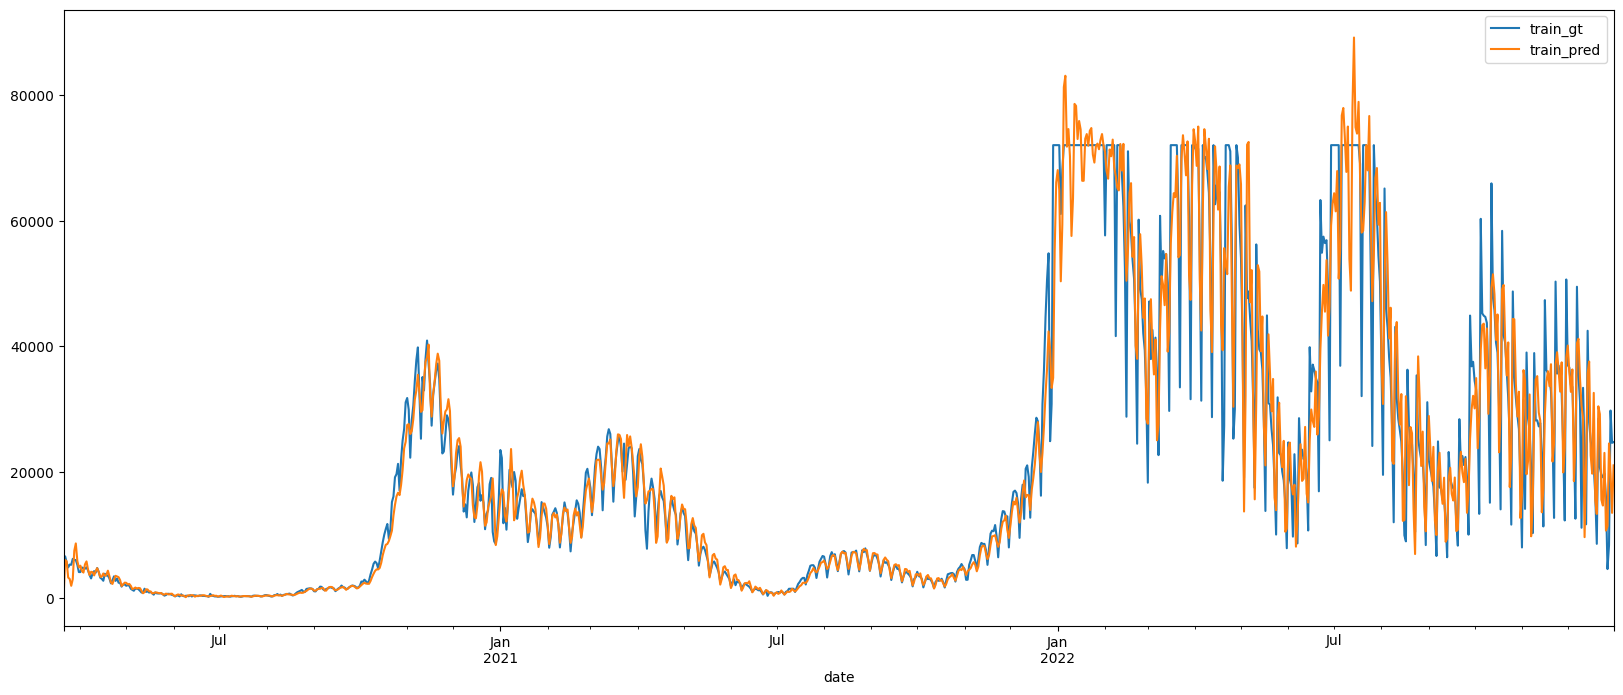

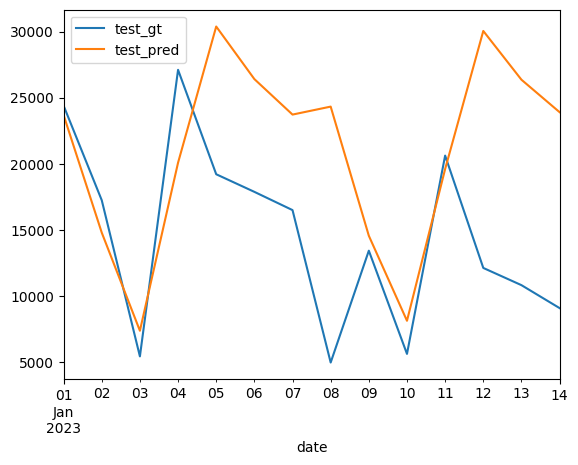

In [61]:
model2_italy = ARIMA(train_italy, order=(5, 1, 4))
model2_italy = model2_italy.fit()
train_pred=model2_italy.fittedvalues
pd.concat([train_italy, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

#test
test_pred = model2_italy.predict(start=len(train_italy), end=len(train_italy)+len(test_italy)-1, dynamic=True)
test_pred.index = test_italy.index
pd.concat([test_italy, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

italy_train_rmse = np.sqrt(mean_squared_error(train_italy, train_pred))
italy_test_rmse = np.sqrt(mean_squared_error(test_italy, test_pred))

print(f'Train RMSE: {italy_train_rmse}')
print(f'Test RMSE: {italy_test_rmse}')

## Auto ARIMA

In [136]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [63]:
from pmdarima.arima import auto_arima
model_auto_italy = auto_arima(train_italy, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model_auto_italy.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.90 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=21972.969, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=21645.622, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=21923.837, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=21557.450, Time=1.95 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=14.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.93 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=21645.422, Time=1.11 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=21427.569, Time=3.56 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=21564.678, Time=0.80 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=6.23 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.35 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=21365.202, Time=7.92 sec
 ARIMA(3,1,0)(1,1,0)[12]             : A

Best model:  ARIMA(5,1,2)(2,1,0)[12]

Train RMSE: 7502.010823006072
Test RMSE: 9940.839922741943


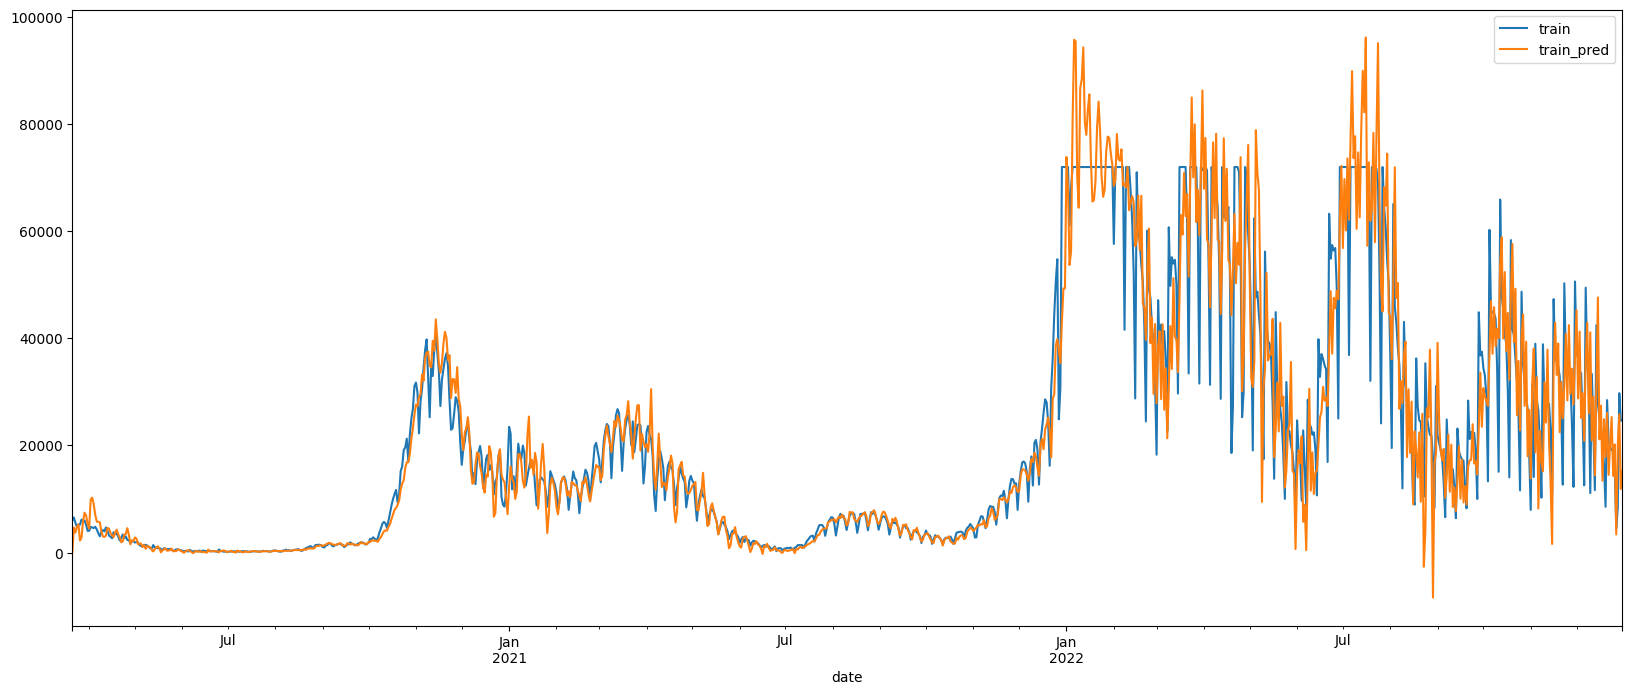

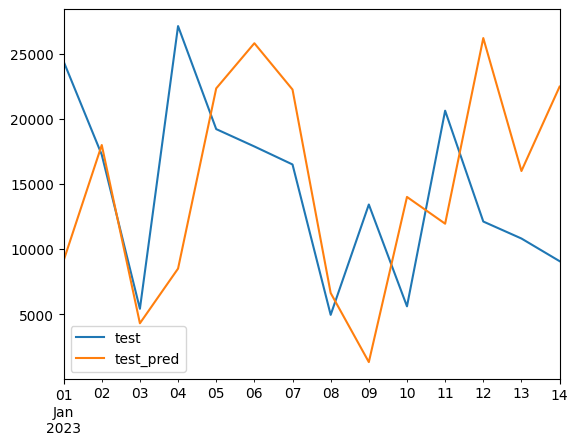

In [67]:
train_pred_italy=model_auto_italy.fittedvalues()
pd.concat([train_italy, train_pred_italy], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])

test_pred_italy=model_auto_italy.predict(n_periods=len(test_italy))
pd.concat([test_italy, test_pred_italy], axis=1).plot()
plt.legend(['test', 'test_pred'])

train_rmse_italy = np.sqrt(mean_squared_error(train_italy, train_pred_italy))
test_rmse_italy = np.sqrt(mean_squared_error(test_italy, test_pred_italy))

print(f'Train RMSE: {train_rmse_italy}')
print(f'Test RMSE: {test_rmse_italy}')

# Stationary

Tuned parameters for Poland and applied to other stationary countries

## ARIMA

In [73]:
train_poland, test_poland = get_country_data('Poland', train, test)
train_poland.shape

(1016,)

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

Train RMSE: 1384.381171955456
Test RMSE: 194.16454700027893


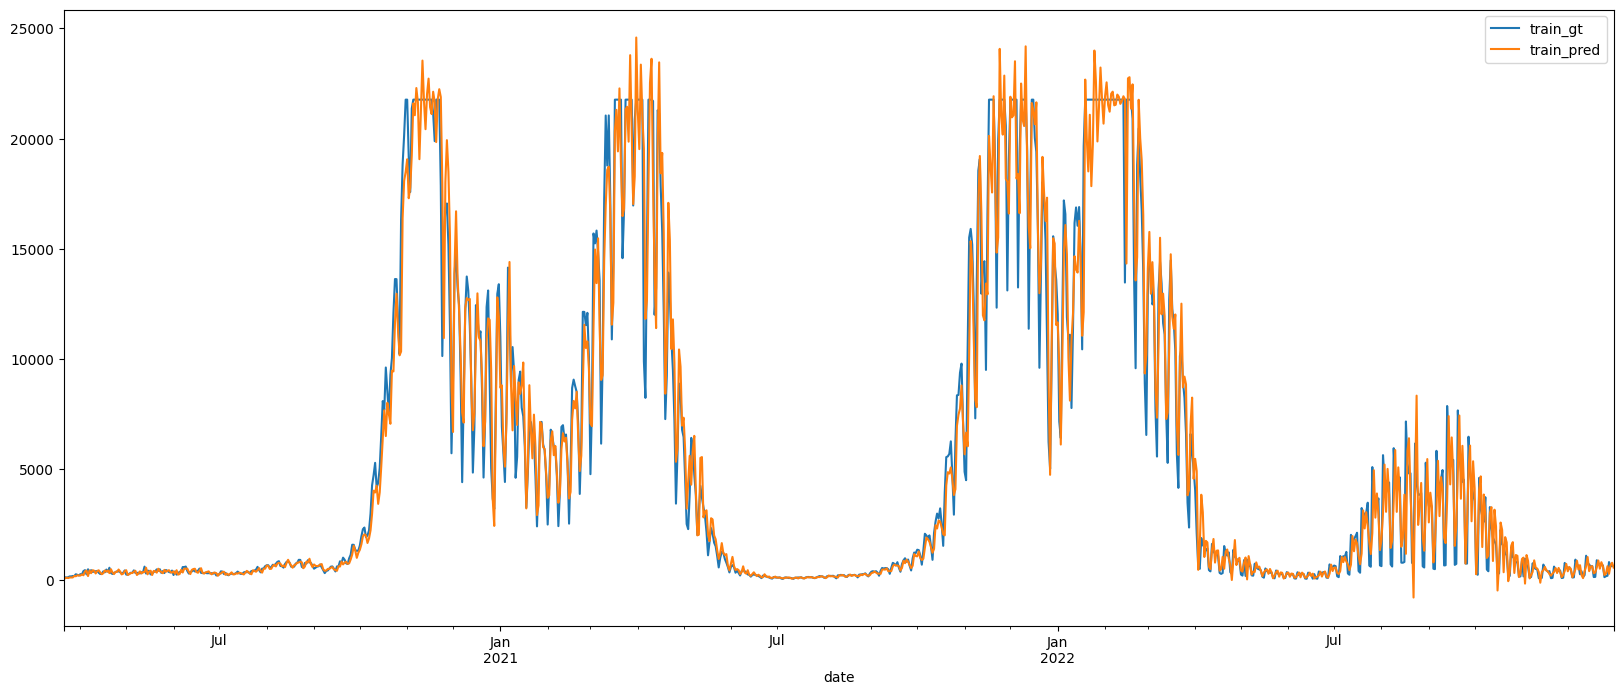

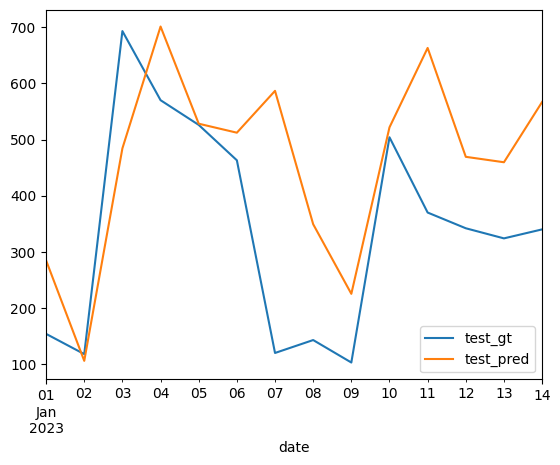

In [74]:
model1_poland = ARIMA(train_poland, order=(5, 1, 3))
model1_poland = model1_poland.fit()
train_pred=model1_poland.fittedvalues
pd.concat([train_poland, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

#test
test_pred = model1_poland.predict(start=len(train_poland), end=len(train_poland)+len(test_poland)-1, dynamic=True)
test_pred.index = test_poland.index
pd.concat([test_poland, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

poland_train_rmse = np.sqrt(mean_squared_error(train_poland, train_pred))
poland_test_rmse = np.sqrt(mean_squared_error(test_poland, test_pred))

print(f'Train RMSE: {poland_train_rmse}')
print(f'Test RMSE: {poland_test_rmse}')

### Grid Search

In [57]:
import itertools
from math import sqrt

p = q = range(0, 6)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
best_score, best_cfg = float("inf"), None

for param in pdq:
    try:
        model = ARIMA(train_poland, order=param)
        model = model.fit()
        train_poland_pred=model.fittedvalues
        error = sqrt(mean_squared_error(train_poland, train_poland_pred))
        if error < best_score:
            best_score, best_cfg = error, param
        print('ARIMA{} - RMSE:{}'.format(param, error))
    except:
        continue

print('Best ARIMA{} RMSE={}'.format(best_cfg, best_score))

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(0, 0, 0) - RMSE:9441.989359502566
ARIMA(0, 0, 1) - RMSE:5180.242603764847


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 2) - RMSE:3620.0897165594997


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 3) - RMSE:3594.4515498920887


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(0, 0, 4) - RMSE:3033.2976053561365


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(0, 0, 5) - RMSE:2453.5695144061756
ARIMA(0, 1, 0) - RMSE:2780.4664143447612
ARIMA(0, 1, 1) - RMSE:2575.666825034357
ARIMA(0, 1, 2) - RMSE:2404.586838114051
ARIMA(0, 1, 3) - RMSE:2338.8448732697716


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 4) - RMSE:2336.863274152046


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 5) - RMSE:2114.527817476369
ARIMA(1, 0, 0) - RMSE:2756.96888102533
ARIMA(1, 0, 1) - RMSE:2527.1610636059
ARIMA(1, 0, 2) - RMSE:2404.343101639707


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(1, 0, 3) - RMSE:2340.044377150026


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(1, 0, 4) - RMSE:2326.6433875123
ARIMA(1, 0, 5) - RMSE:2113.8507840947277
ARIMA(1, 1, 0) - RMSE:2718.1387725653753
ARIMA(1, 1, 1) - RMSE:2530.804910946583
ARIMA(1, 1, 2) - RMSE:2362.362604962211


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(1, 1, 3) - RMSE:2335.5900268515934


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 4) - RMSE:2162.3785909194603


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 5) - RMSE:2114.414040256232
ARIMA(2, 0, 0) - RMSE:2678.5555057226998
ARIMA(2, 0, 1) - RMSE:2497.64588186654


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(2, 0, 2) - RMSE:2363.130687686825


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(2, 0, 3) - RMSE:2336.8258133763843


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 4) - RMSE:2170.6396945267816


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(2, 0, 5) - RMSE:2120.75144609385
ARIMA(2, 1, 0) - RMSE:2431.6391780623803
ARIMA(2, 1, 1) - RMSE:2353.7104904266257
ARIMA(2, 1, 2) - RMSE:2321.5358728894143


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/ba

ARIMA(2, 1, 3) - RMSE:2045.9611431364497


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 4) - RMSE:1985.9044897742351


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(2, 1, 5) - RMSE:1857.485796228041
ARIMA(3, 0, 0) - RMSE:2423.0263233773194
ARIMA(3, 0, 1) - RMSE:2417.677389824834
ARIMA(3, 0, 2) - RMSE:2342.8642247077914


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(3, 0, 3) - RMSE:2048.3924045252543


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(3, 0, 4) - RMSE:1984.8950741567448


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(3, 0, 5) - RMSE:1844.1309820276274
ARIMA(3, 1, 0) - RMSE:2431.20696081935
ARIMA(3, 1, 1) - RMSE:2413.8066782919996


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 2) - RMSE:2086.9417966198375
ARIMA(3, 1, 3) - RMSE:2377.763397000802


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 4) - RMSE:1961.4395741774872


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(3, 1, 5) - RMSE:1829.4265566209638
ARIMA(4, 0, 0) - RMSE:2422.990447959434
ARIMA(4, 0, 1) - RMSE:2404.290235322729


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(4, 0, 2) - RMSE:2260.2750090531395


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 3) - RMSE:2006.46366189798


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 4) - RMSE:1966.888759071948


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(4, 0, 5) - RMSE:1833.4849161016787
ARIMA(4, 1, 0) - RMSE:2193.50810670419
ARIMA(4, 1, 1) - RMSE:2113.4463512684397


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 2) - RMSE:1782.5860667387808


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(4, 1, 3) - RMSE:1772.2040613549534


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 4) - RMSE:1574.0364760547852


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 5) - RMSE:1570.8262128813294
ARIMA(5, 0, 0) - RMSE:2196.3388223338115


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

ARIMA(5, 0, 1) - RMSE:2119.1436612471066


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(5, 0, 2) - RMSE:1790.1901721899933


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 3) - RMSE:1859.533612991542


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 4) - RMSE:1584.8481280408014


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(5, 0, 5) - RMSE:1581.6076549014026
ARIMA(5, 1, 0) - RMSE:1965.8885235079556
ARIMA(5, 1, 1) - RMSE:1953.0926850035517


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 1, 2) - RMSE:1698.6184524902537


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

ARIMA(5, 1, 3) - RMSE:1698.0459560412614


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

ARIMA(5, 1, 4) - RMSE:1565.3984550729565
ARIMA(5, 1, 5) - RMSE:1567.7364839313589
Best ARIMA(5, 1, 4) RMSE=1565.3984550729565


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train RMSE: 1565.3984550729565
Test RMSE: 253.39195151024703


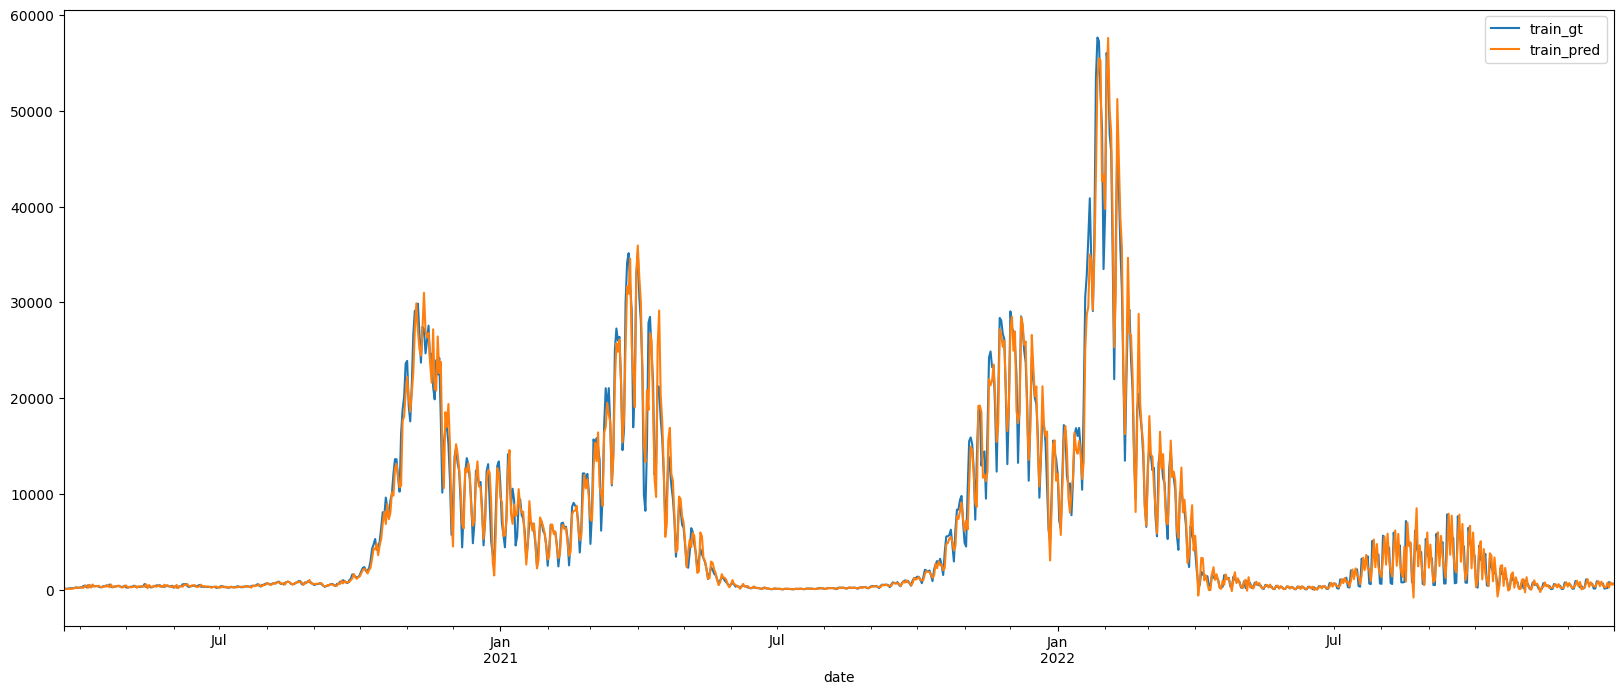

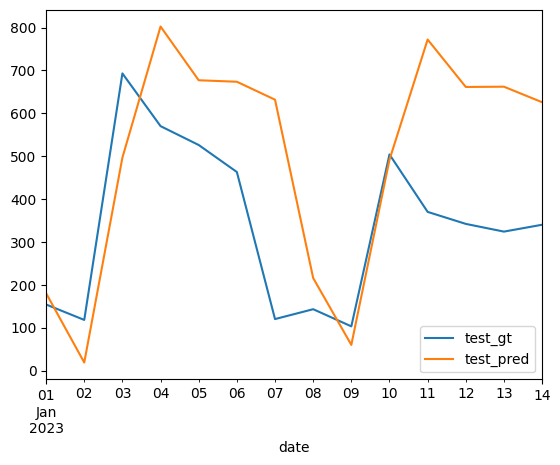

In [58]:
model2_poland = ARIMA(train_poland, order=(5, 1, 4))
model2_poland = model2_poland.fit()
train_pred=model2_poland.fittedvalues
pd.concat([train_poland, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

#test
test_pred = model2_poland.predict(start=len(train_poland), end=len(train_poland)+len(test_poland)-1, dynamic=True)
test_pred.index = test_poland.index
pd.concat([test_poland, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

poland_train_rmse = np.sqrt(mean_squared_error(train_poland, train_pred))
poland_test_rmse = np.sqrt(mean_squared_error(test_poland, test_pred))

print(f'Train RMSE: {poland_train_rmse}')
print(f'Test RMSE: {poland_test_rmse}')

In [ ]:
rmse_results = {}
location_stationary = ['Poland', 'Lithuania']

for country in location_stationary:
    train_country, test_country = get_country_data(country, train, test) 
    
    # Fit the ARIMA model
    model_country = ARIMA(train_country, order = (5, 1, 4))  
    model_country = model_country.fit()

    print(test_country.shape)

    # Make predictions
    train_pred = model_country.fittedvalues
    pd.concat([train_country, train_pred], axis=1).plot(figsize=(20, 8))
    plt.legend(['train_gt', 'train_pred'])

    test_pred = model_country.predict(start=len(train_country), end=len(train_country)+len(test_country)-1, dynamic=True)
    test_pred.index = test_country.index
    pd.concat([test_country, test_pred], axis=1).plot()
    plt.legend(['test_gt', 'test_pred'])


    # Calculate RMSE
    train_rmse = sqrt(mean_squared_error(train_country, train_pred))
    test_rmse = sqrt(mean_squared_error(test_country, test_pred))
    rmse_results[country] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}

    print(f'{country} - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')

# Convert RMSE results to DataFrame
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)


## Auto ARIMA

In [17]:
from pmdarima.arima import auto_arima
model_auto_poland = auto_arima(train_poland, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model_auto_poland.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=19118.115, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18710.687, Time=1.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=19118.061, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=18543.675, Time=5.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.92 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.52 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=18547.001, Time=0.86 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=18390.922, Time=5.00 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=18588.935, Time=0.71 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=7.60 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.90 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=18402.883, Time=6.89 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AI

Best model:  ARIMA(5,1,4)(2,1,0)[12]

Train RMSE: 1507.8097014368477
Test RMSE: 302.4244945596769


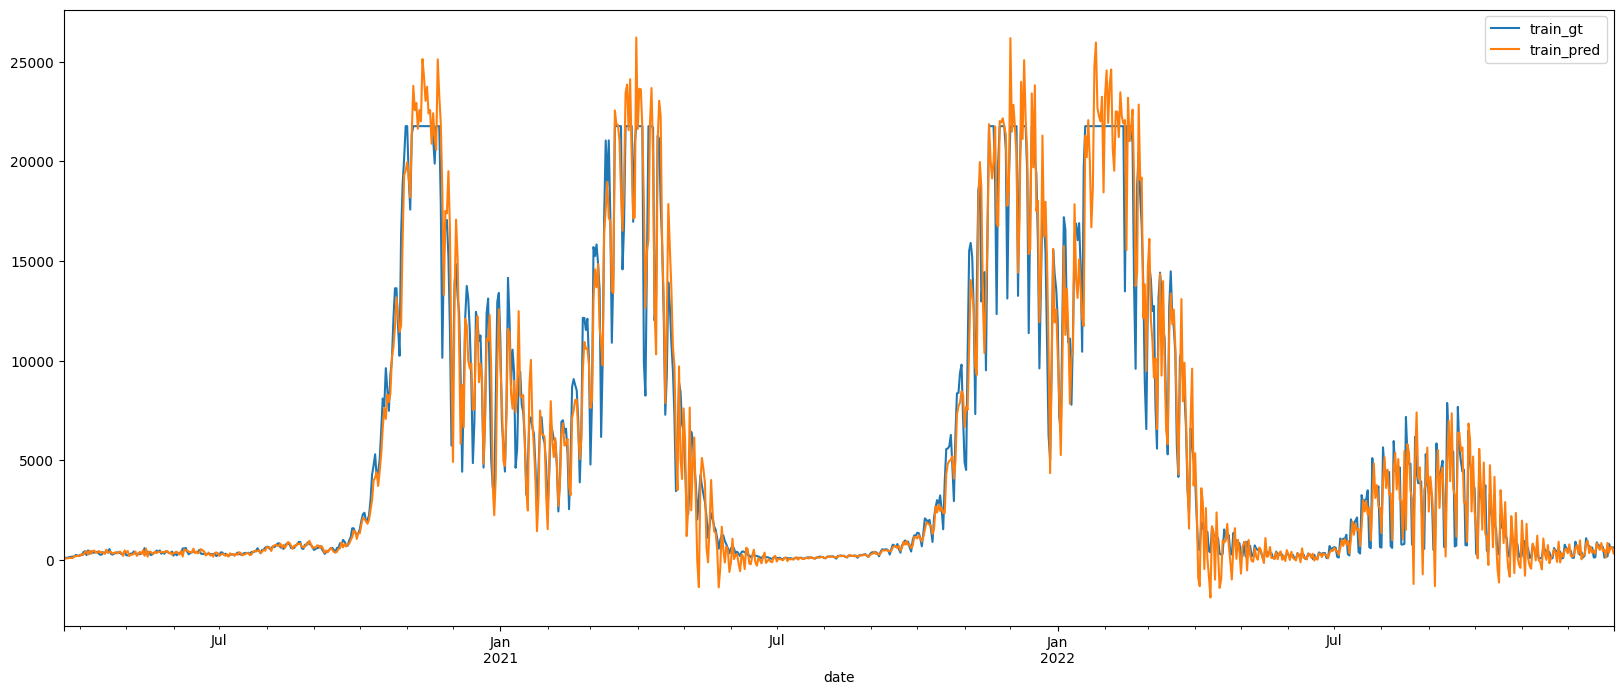

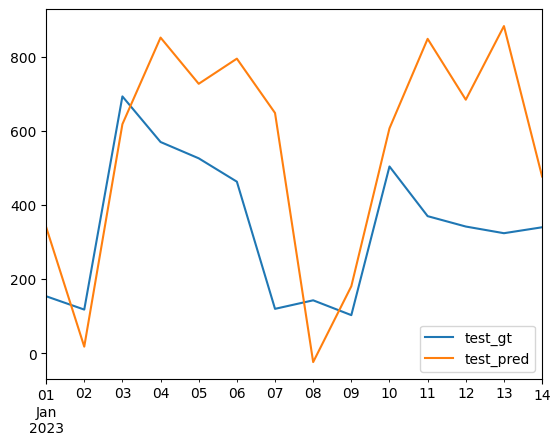

In [70]:
train_pred=model_auto_poland.fittedvalues()
pd.concat([train_poland, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

#test
test_pred = model_auto_poland.predict(n_periods=len(test_poland))
# test_pred.index = test_poland.index
pd.concat([test_poland, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

poland_train_rmse = np.sqrt(mean_squared_error(train_poland, train_pred))
poland_test_rmse = np.sqrt(mean_squared_error(test_poland, test_pred))

print(f'Train RMSE: {poland_train_rmse}')
print(f'Test RMSE: {poland_test_rmse}')

## Applying ARIMA Parameters to all other countries

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

(14,)
Belgium - Train RMSE: 1080.7501049498394, Test RMSE: 425.30108158327323


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(14,)
Denmark - Train RMSE: 192.35670708351986, Test RMSE: 568.4224235877685


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/

(14,)
Finland - Train RMSE: 312.45922792843874, Test RMSE: 103.05595485977759


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(14,)
Ireland - Train RMSE: 322.829136252814, Test RMSE: 253.7969155064136


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/

(14,)
Italy - Train RMSE: 6715.849476466177, Test RMSE: 9813.377705564164
(14,)
Norway - Train RMSE: 102.29934697374175, Test RMSE: 75.52338085449516


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_mo

(14,)
Switzerland - Train RMSE: 710.7159110205971, Test RMSE: 616.6532011569325
(14,)
United Kingdom - Train RMSE: 3507.295820886162, Test RMSE: 2873.14244789601


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

(14,)
Poland - Train RMSE: 1384.381171955456, Test RMSE: 194.16454700027893


/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/m

(14,)
Lithuania - Train RMSE: 271.15744229386956, Test RMSE: 216.8733740300311
                 train_rmse    test_rmse
Belgium         1080.750105   425.301082
Denmark          192.356707   568.422424
Finland          312.459228   103.055955
Ireland          322.829136   253.796916
Italy           6715.849476  9813.377706
Norway           102.299347    75.523381
Switzerland      710.715911   616.653201
United Kingdom  3507.295821  2873.142448
Poland          1384.381172   194.164547
Lithuania        271.157442   216.873374


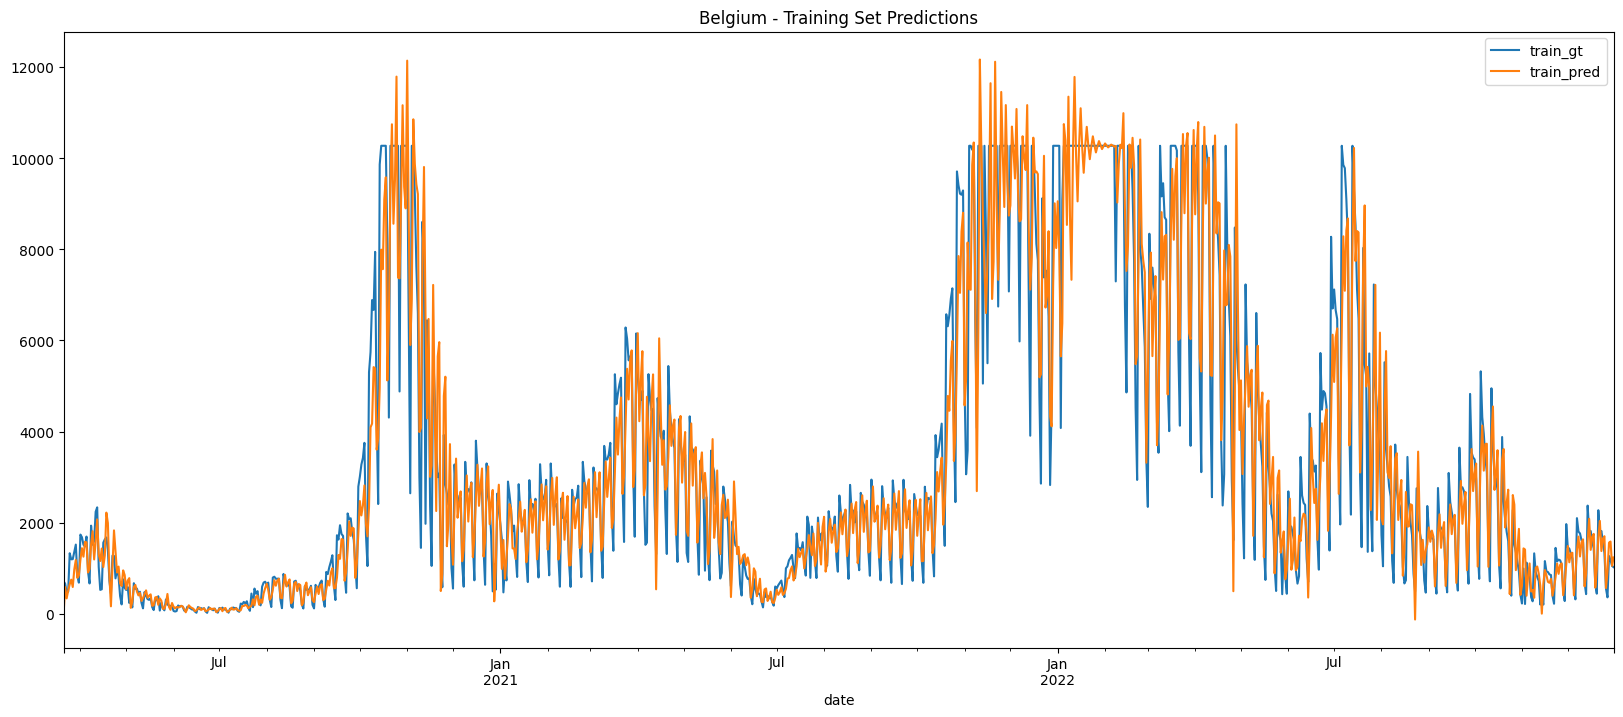

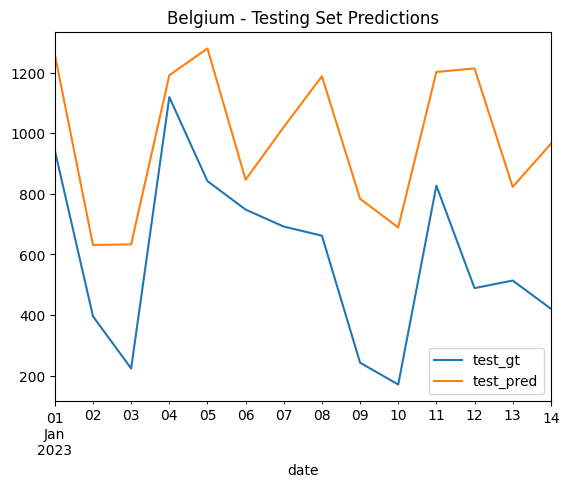

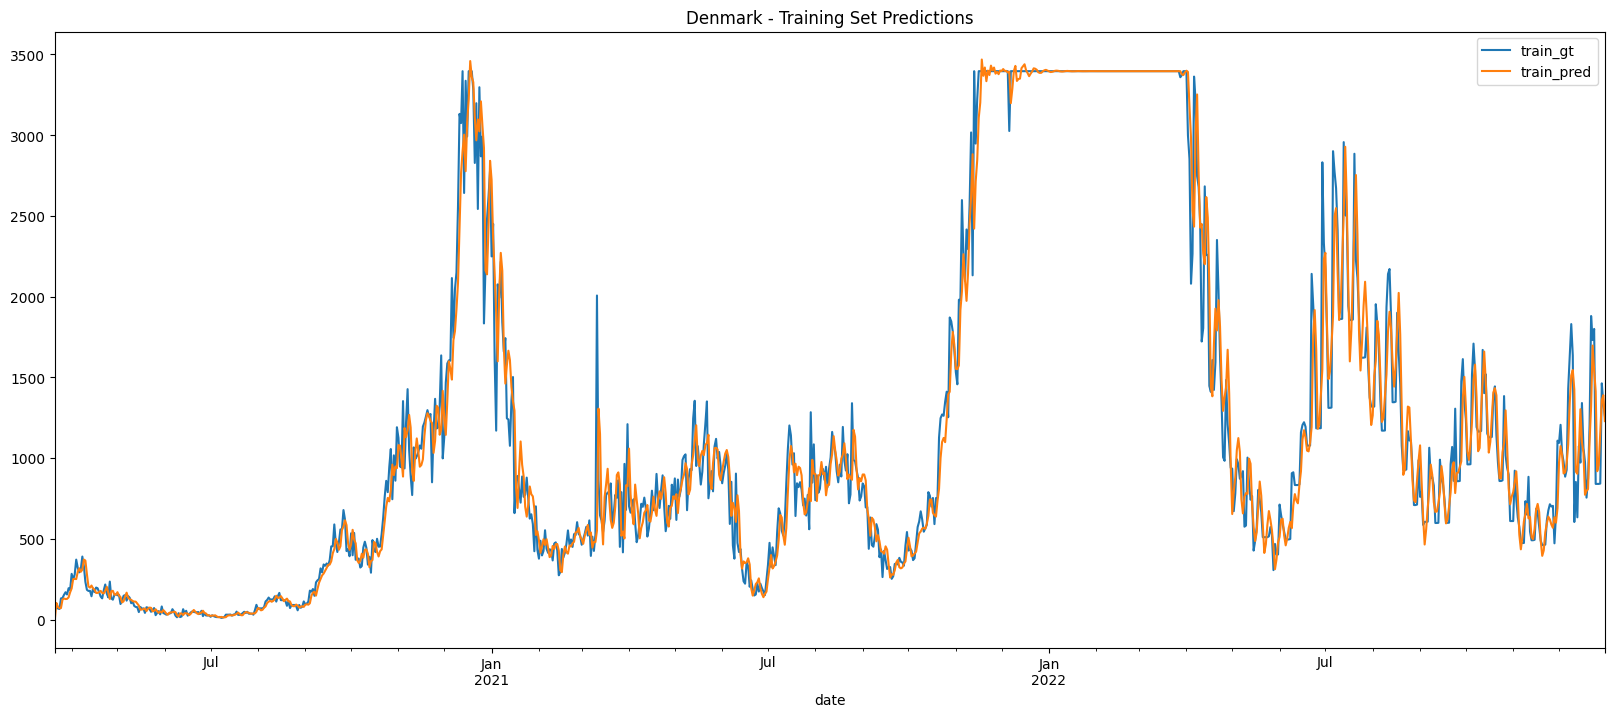

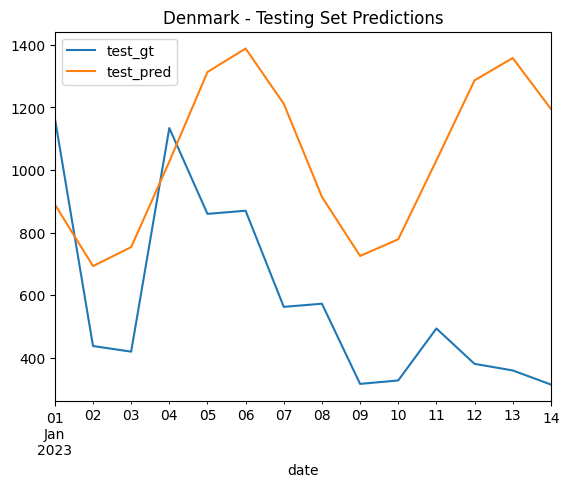

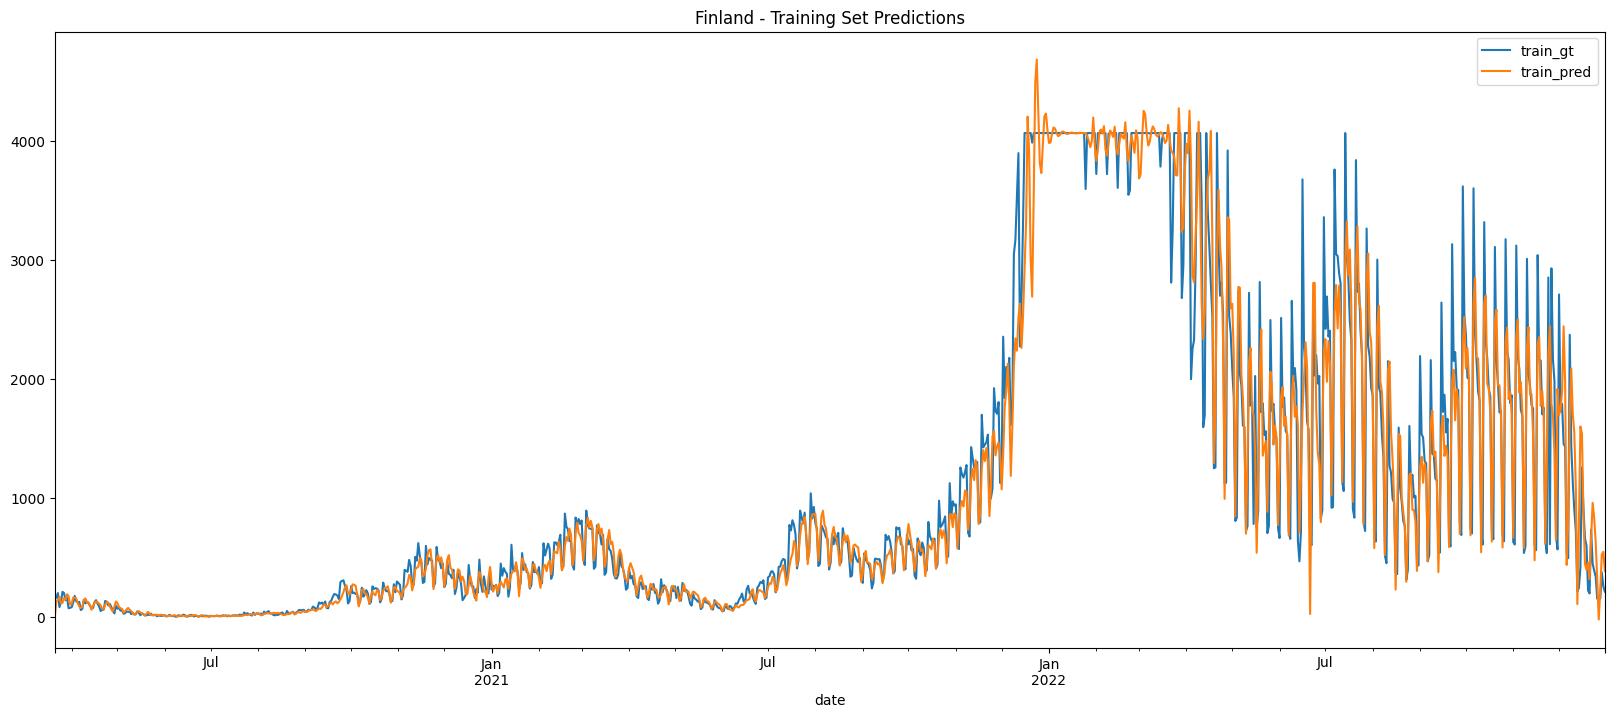

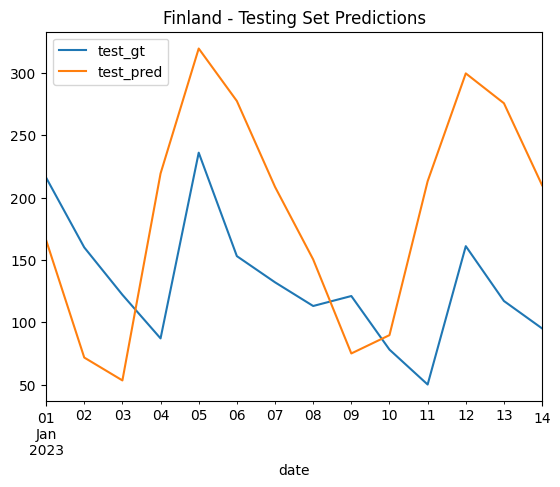

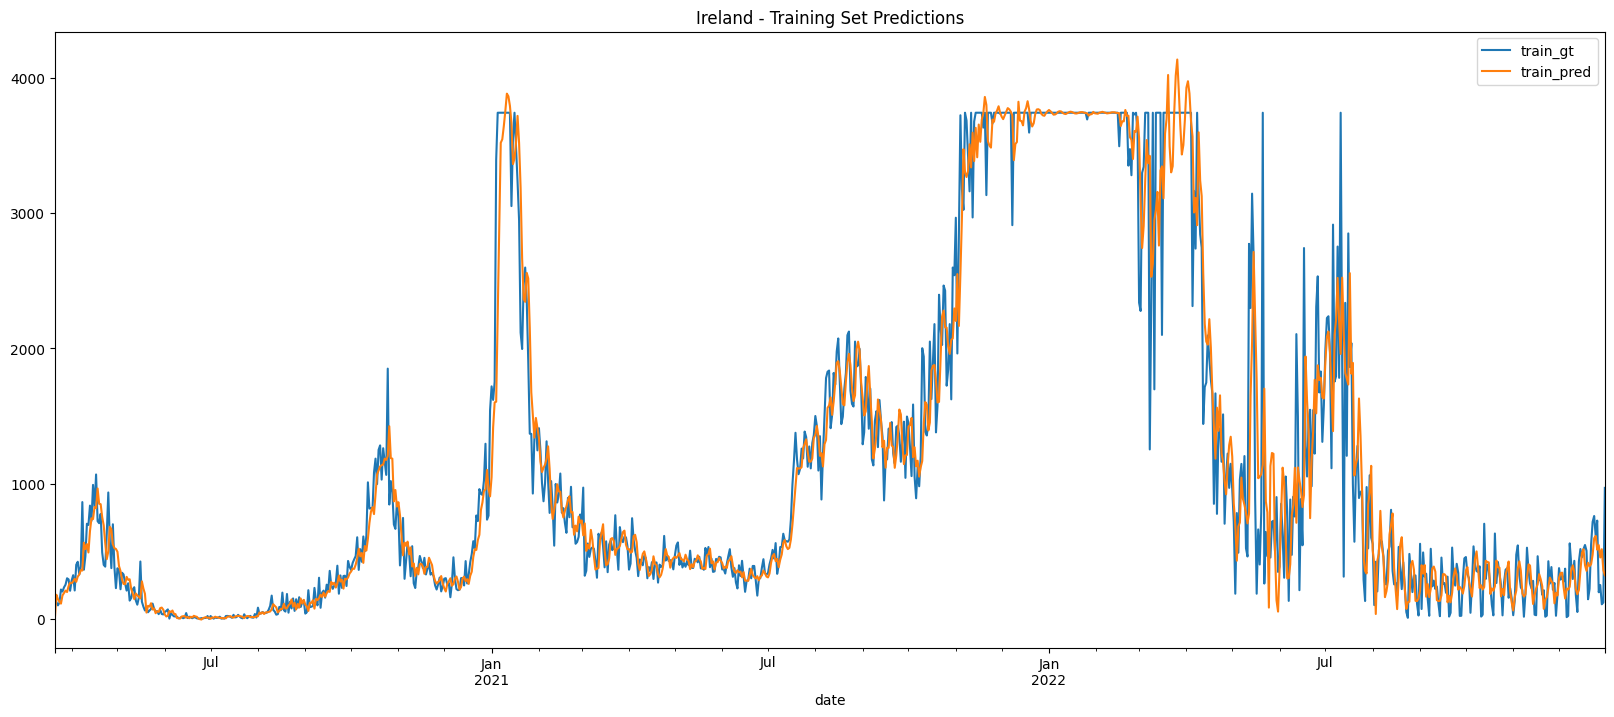

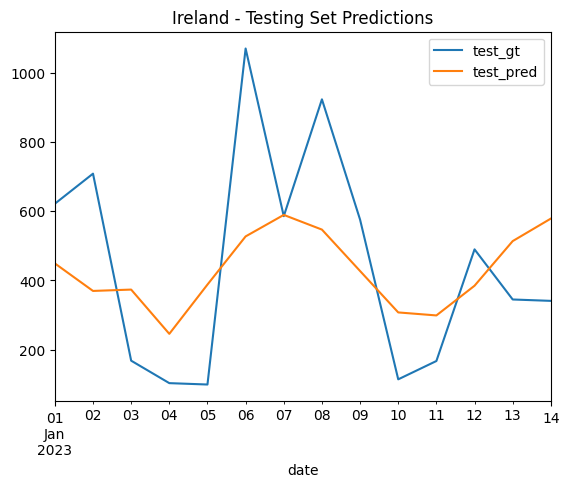

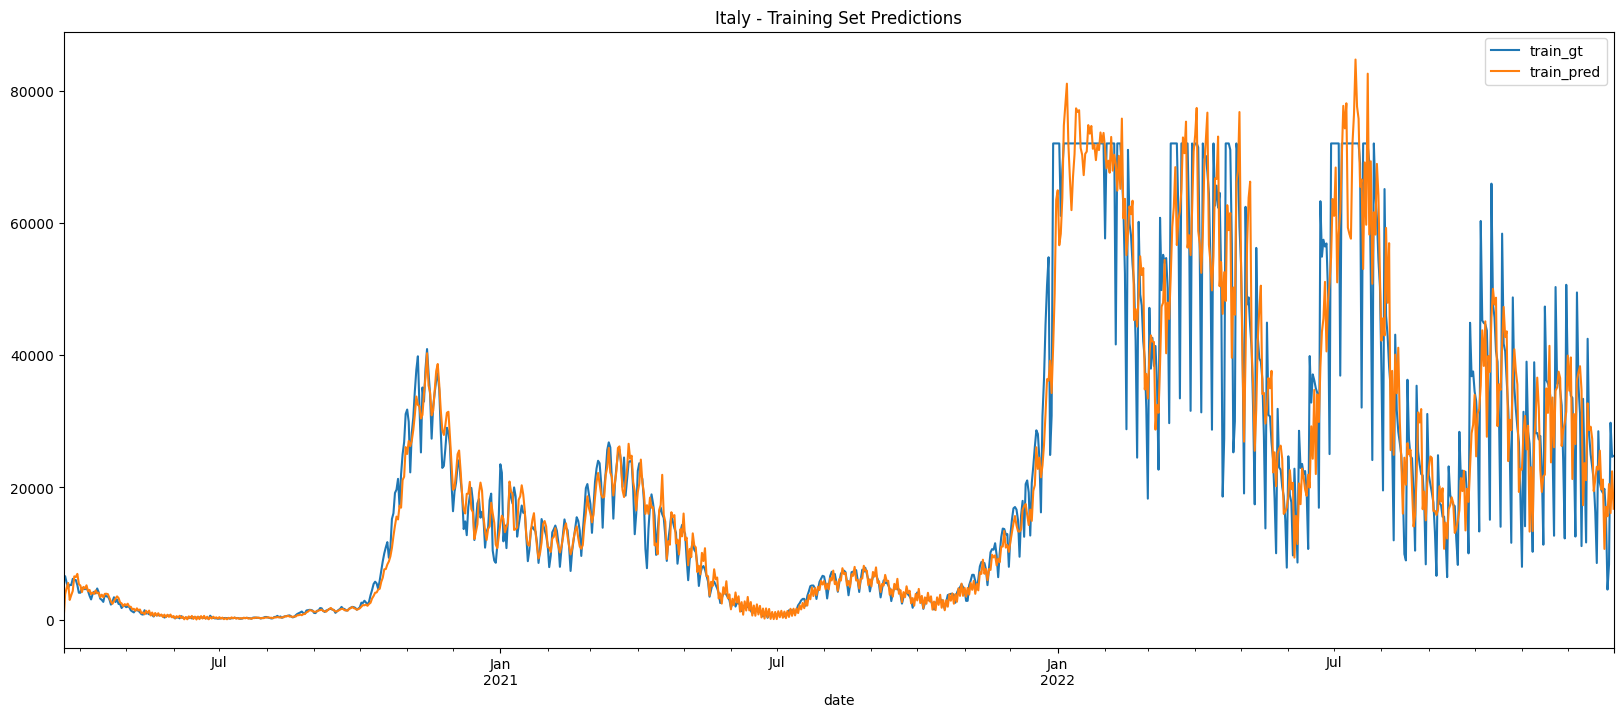

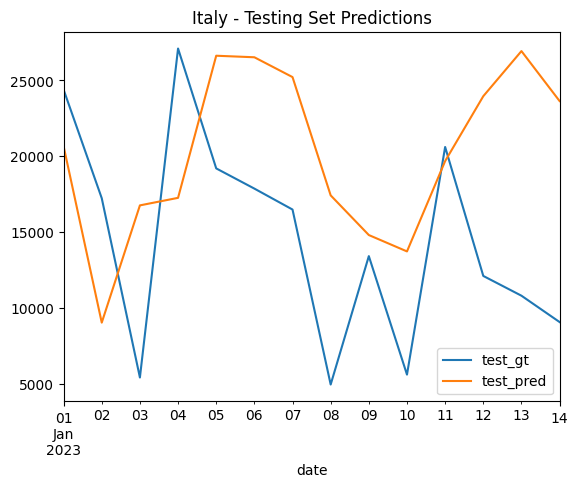

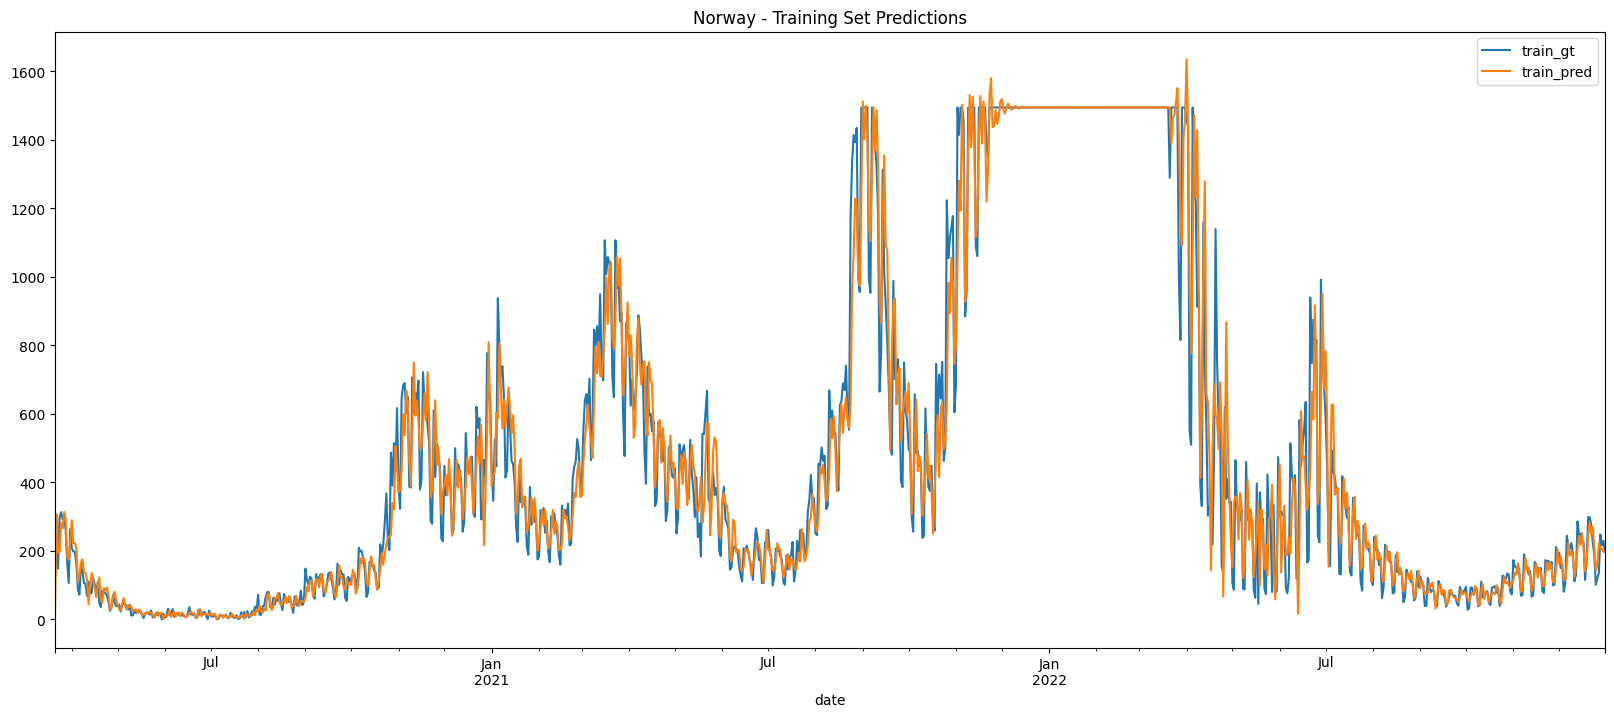

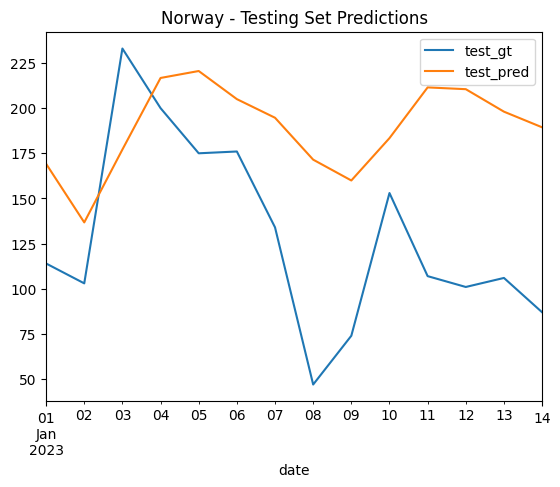

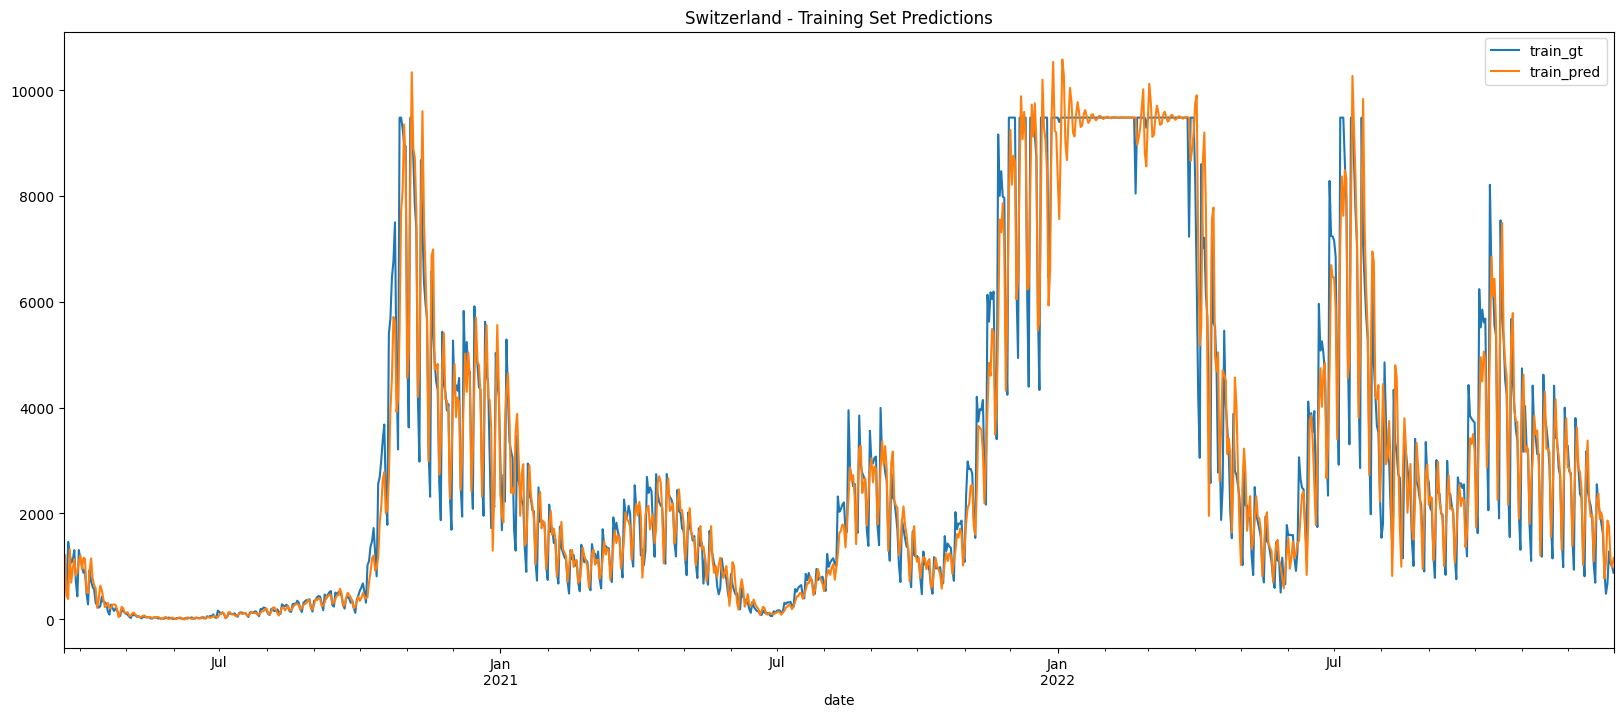

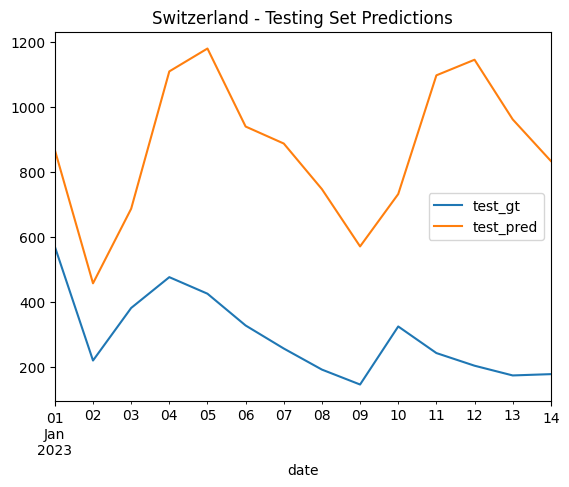

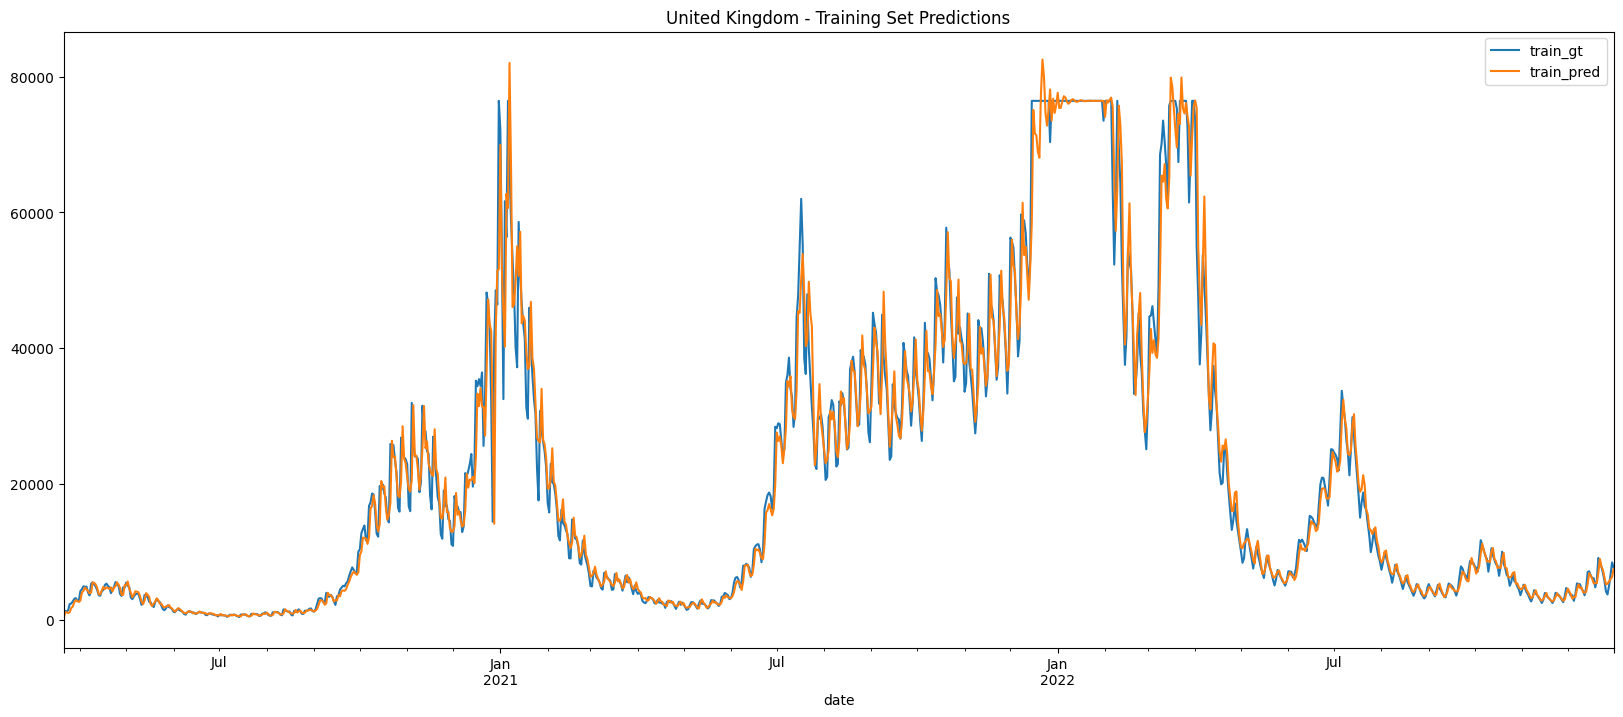

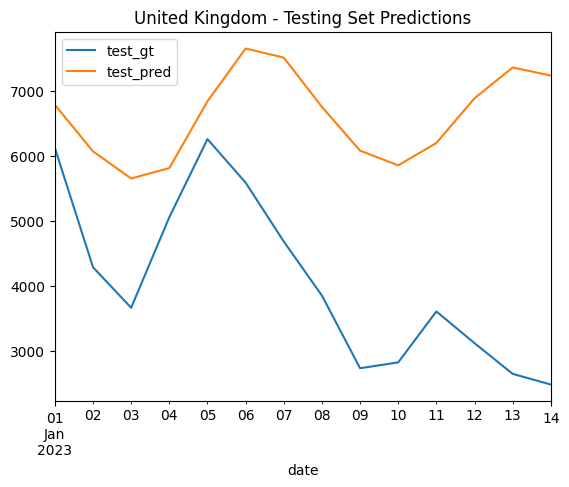

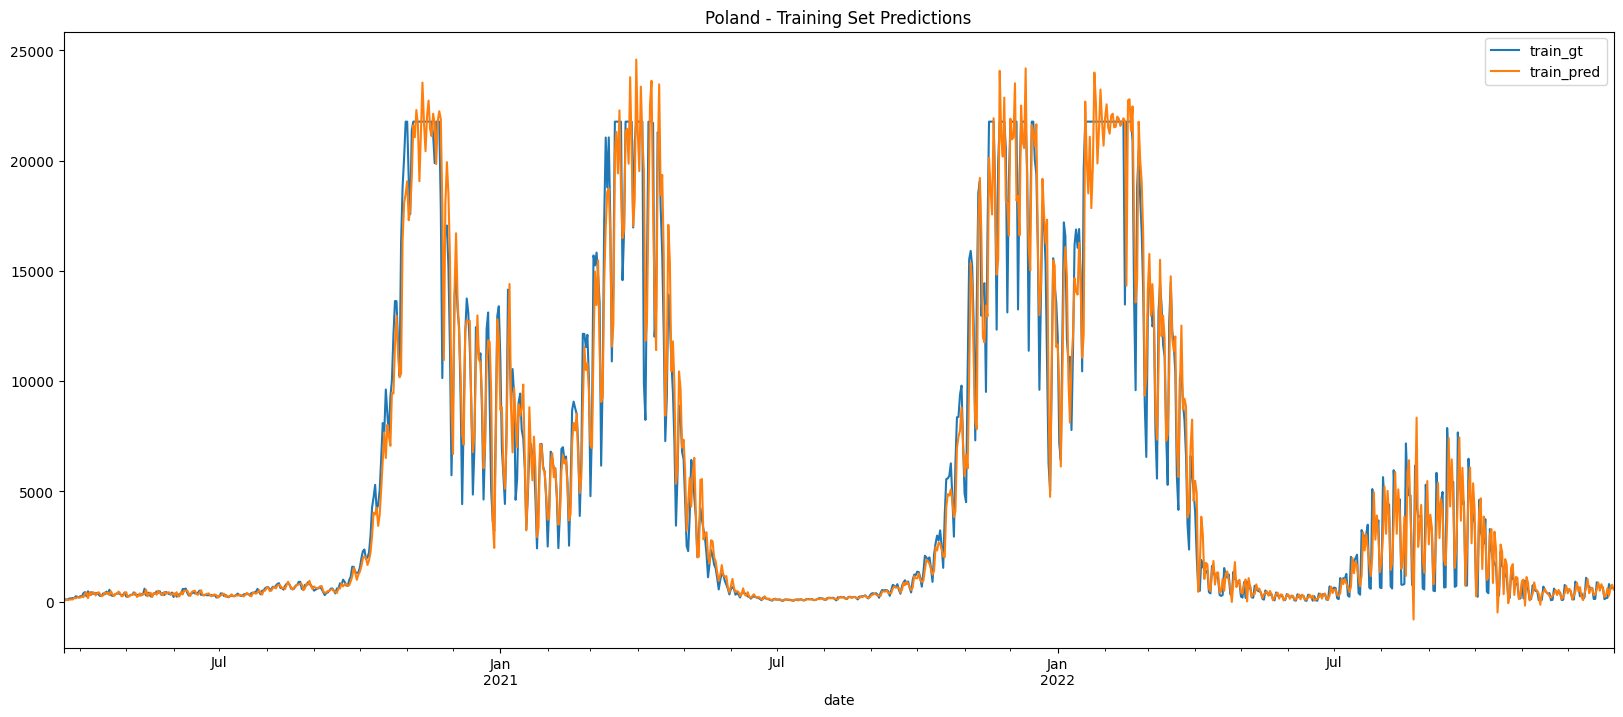

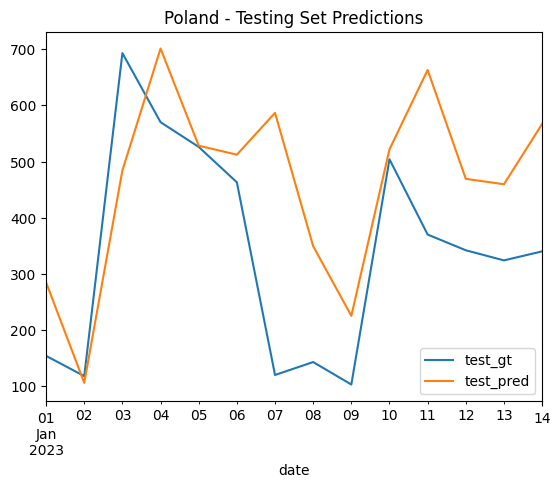

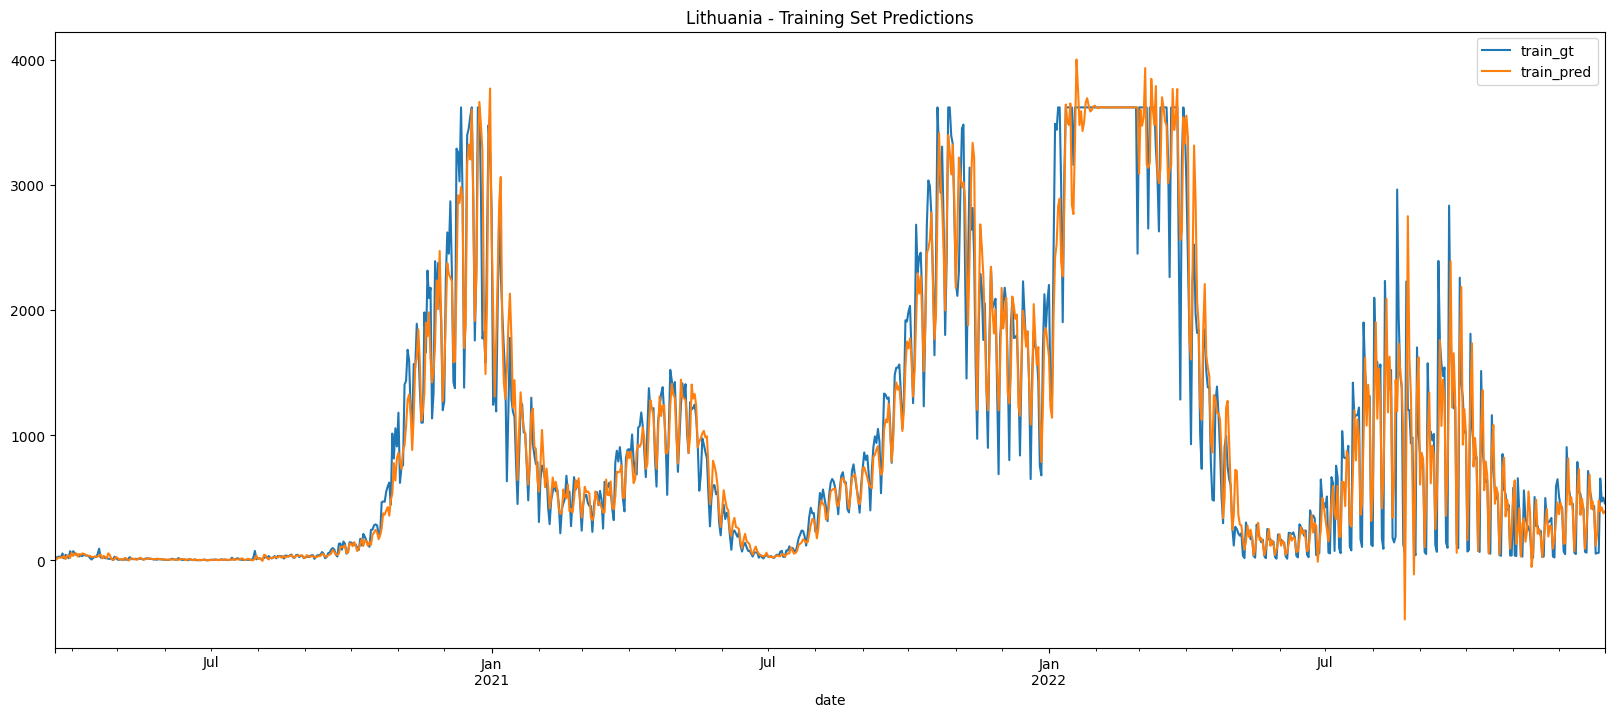

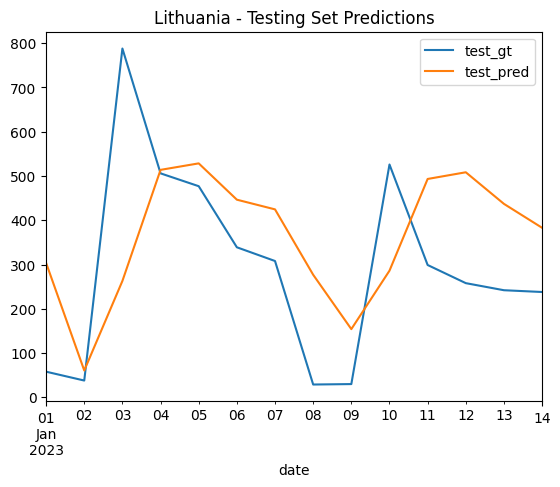

In [10]:
rmse_results = {}
country_list = ['Belgium', 'Denmark', 'Finland', 'Ireland', 'Italy', 'Norway', 'Switzerland', 'United Kingdom', 'Poland', 'Lithuania']

for country in country_list:
    train_country, test_country = get_country_data(country, train, test) 
    
    # Fit the ARIMA model
    model_country = ARIMA(train_country, order = (5, 1, 3))  
    model_country = model_country.fit()

    print(test_country.shape)

    # Make predictions
    train_pred = model_country.fittedvalues
    pd.concat([train_country, train_pred], axis=1).plot(figsize=(20, 8))
    plt.legend(['train_gt', 'train_pred'])
    plt.title(f'{country} - Training Set Predictions')

    test_pred = model_country.predict(start=len(train_country), end=len(train_country)+len(test_country)-1, dynamic=True)
    test_pred.index = test_country.index
    pd.concat([test_country, test_pred], axis=1).plot()
    plt.legend(['test_gt', 'test_pred'])
    plt.title(f'{country} - Testing Set Predictions')

    # Calculate RMSE
    train_rmse = sqrt(mean_squared_error(train_country, train_pred))
    test_rmse = sqrt(mean_squared_error(test_country, test_pred))
    rmse_results[country] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}

    print(f'{country} - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')

# Convert RMSE results to DataFrame
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)


## Auto ARIMA for all countries

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18738.228, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18272.992, Time=2.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18721.263, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=18091.647, Time=3.74 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=18150.391, Time=0.80 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=18030.546, Time=2.86 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=18217.633, Time=0.75 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.19 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.26 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=17921.909, Time=6.84 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

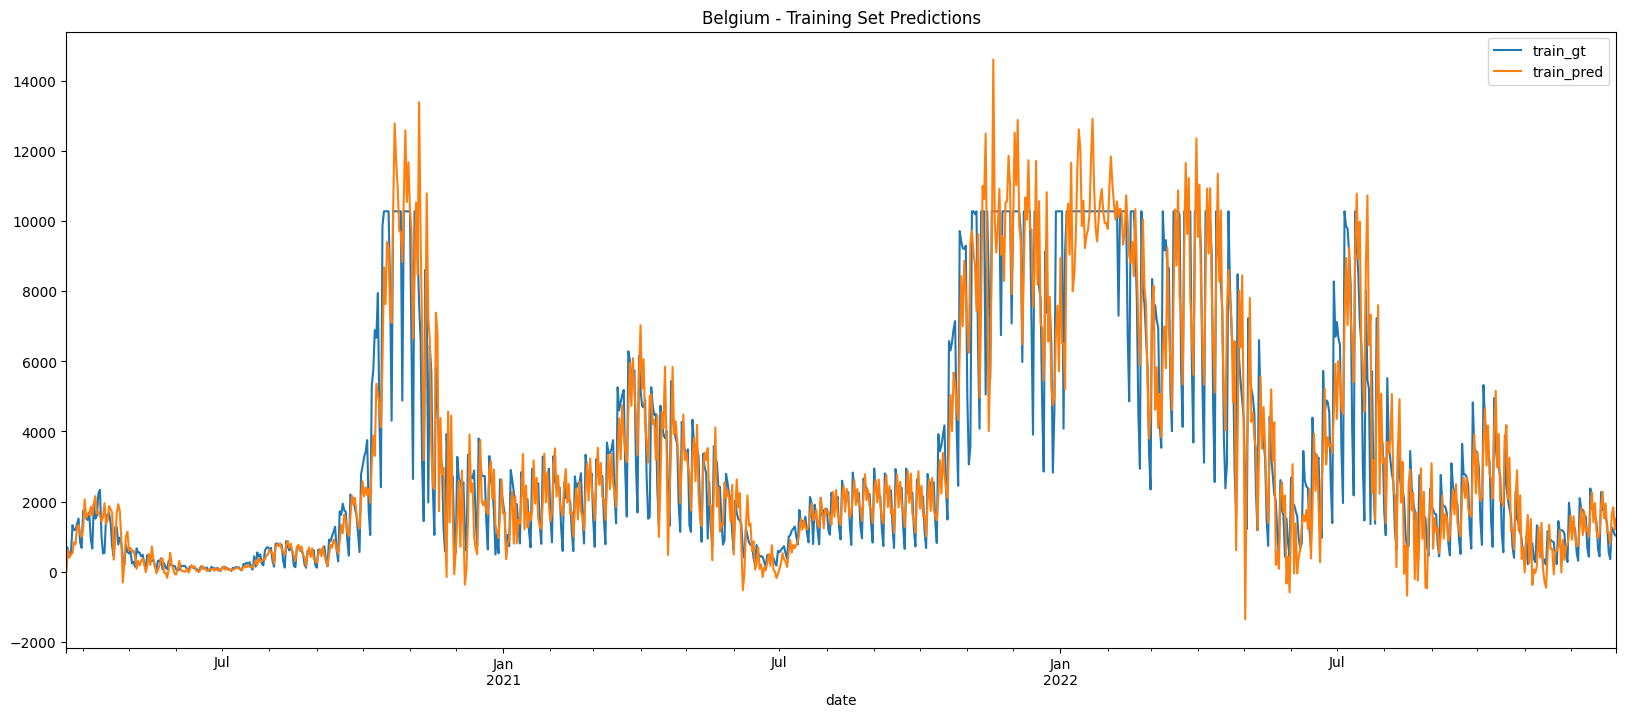

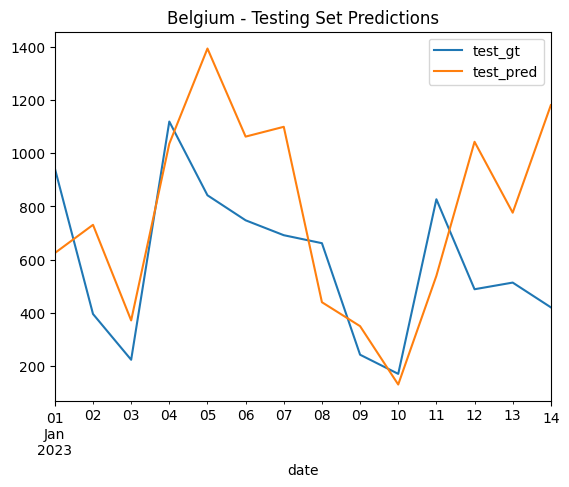

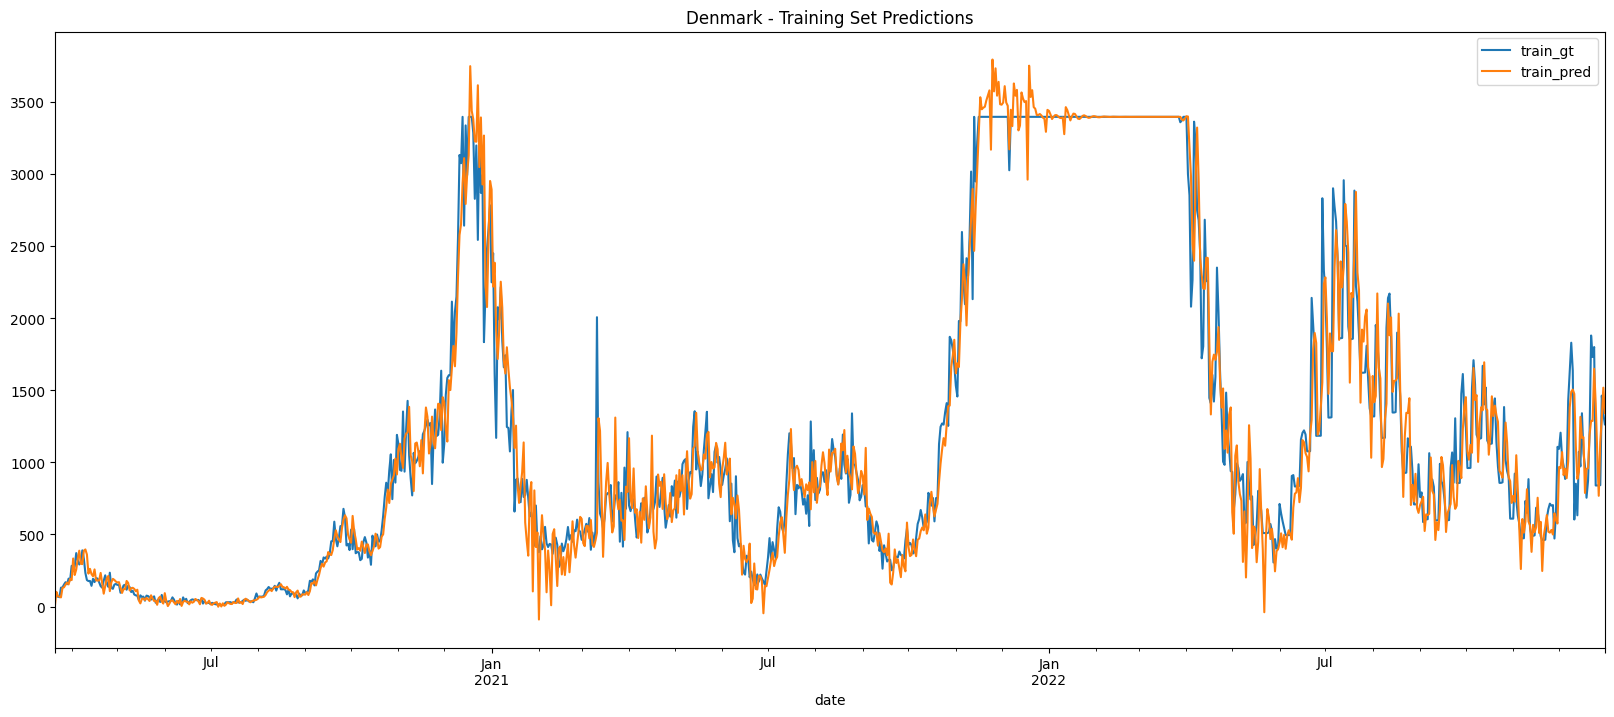

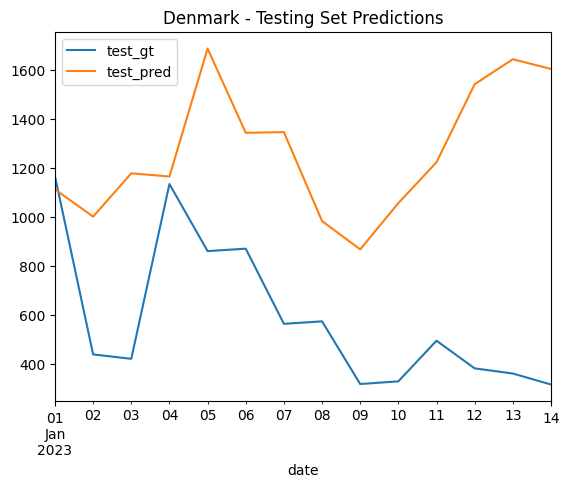

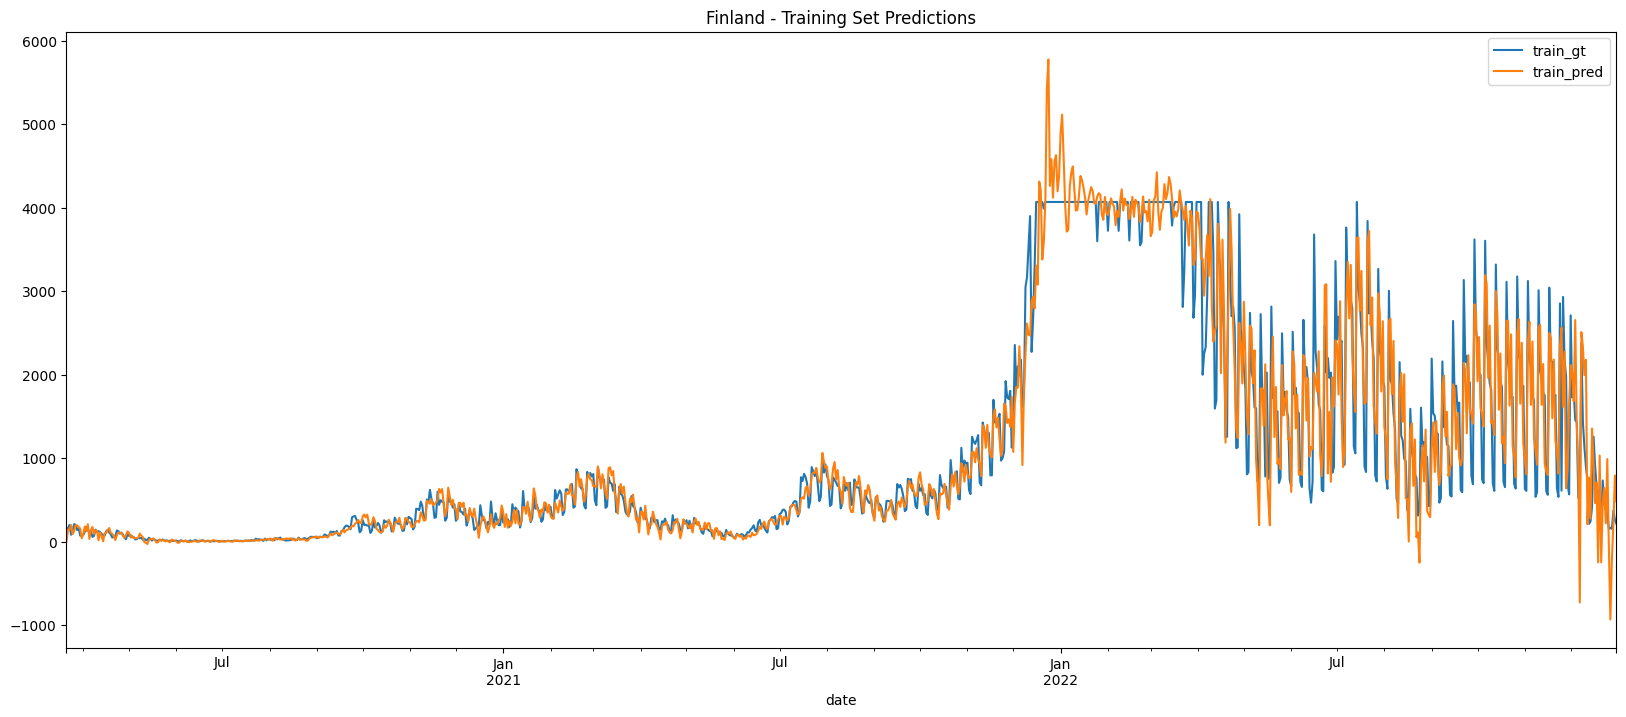

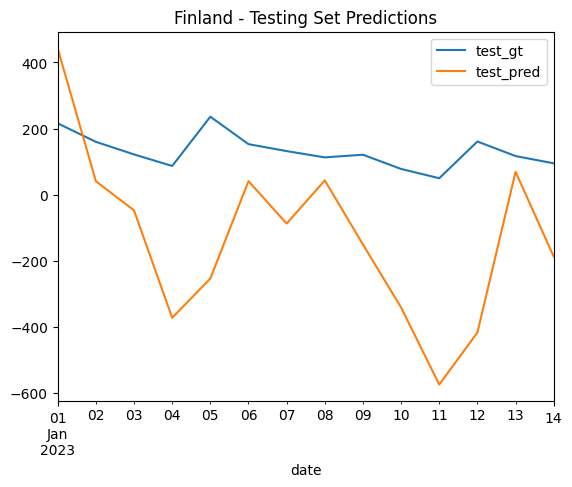

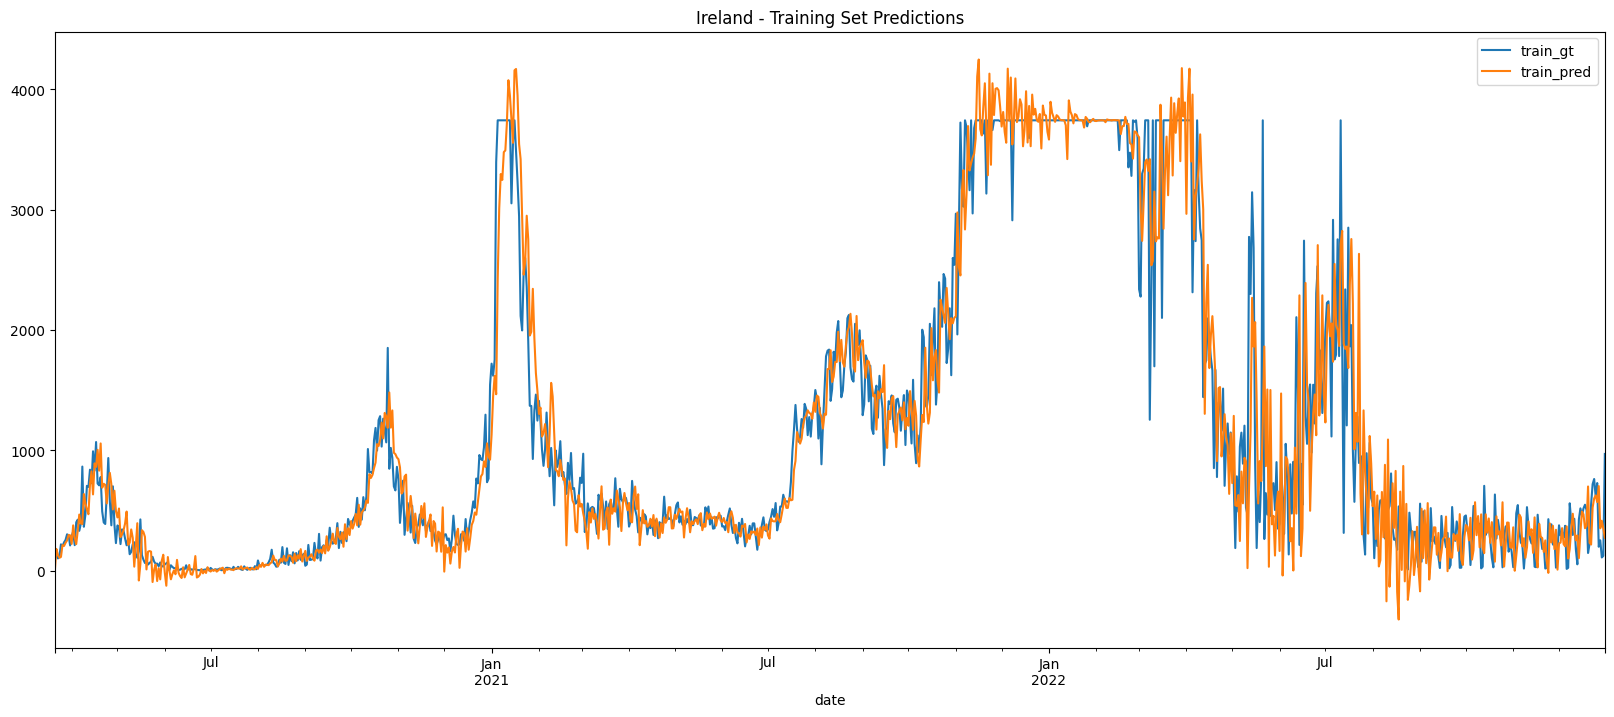

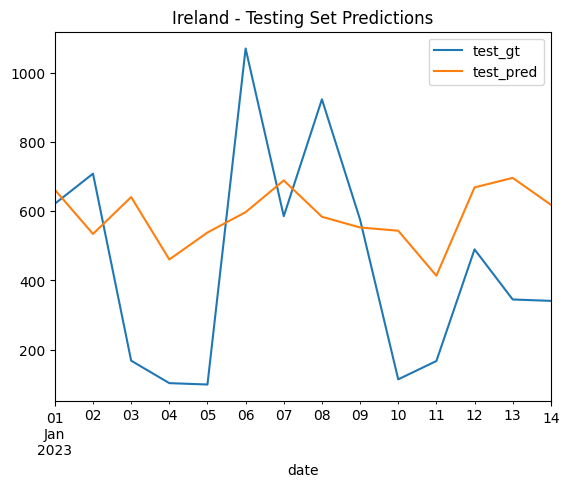

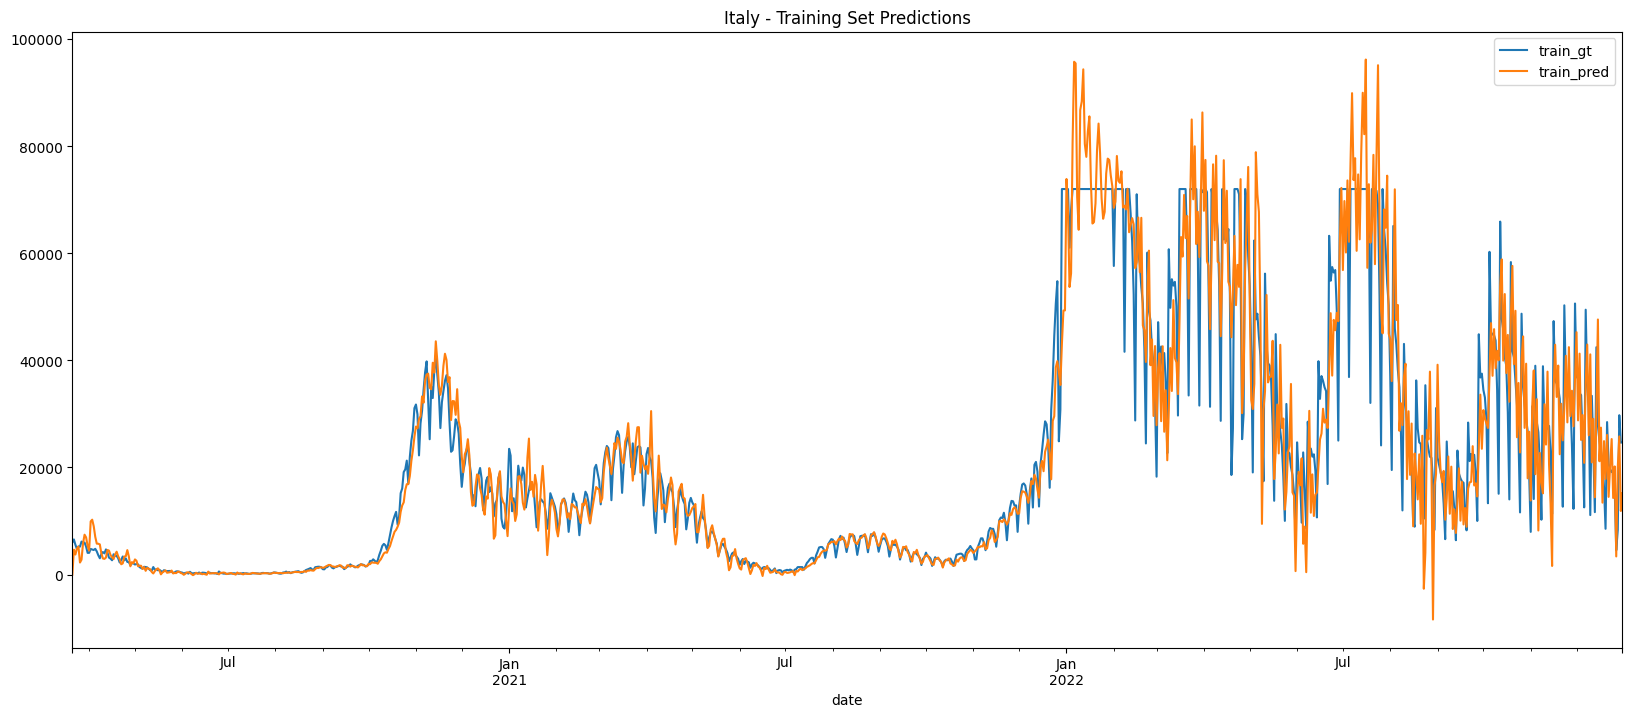

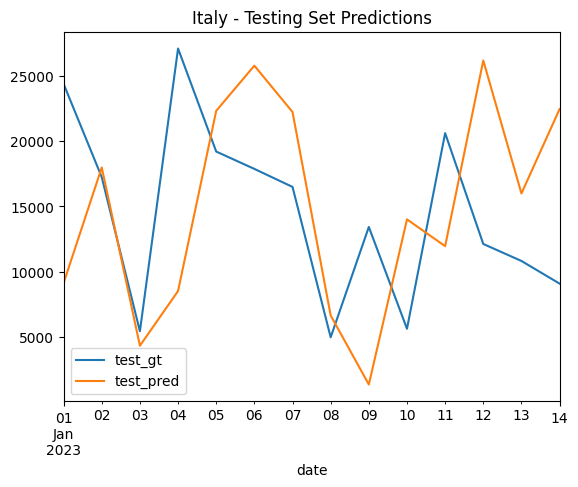

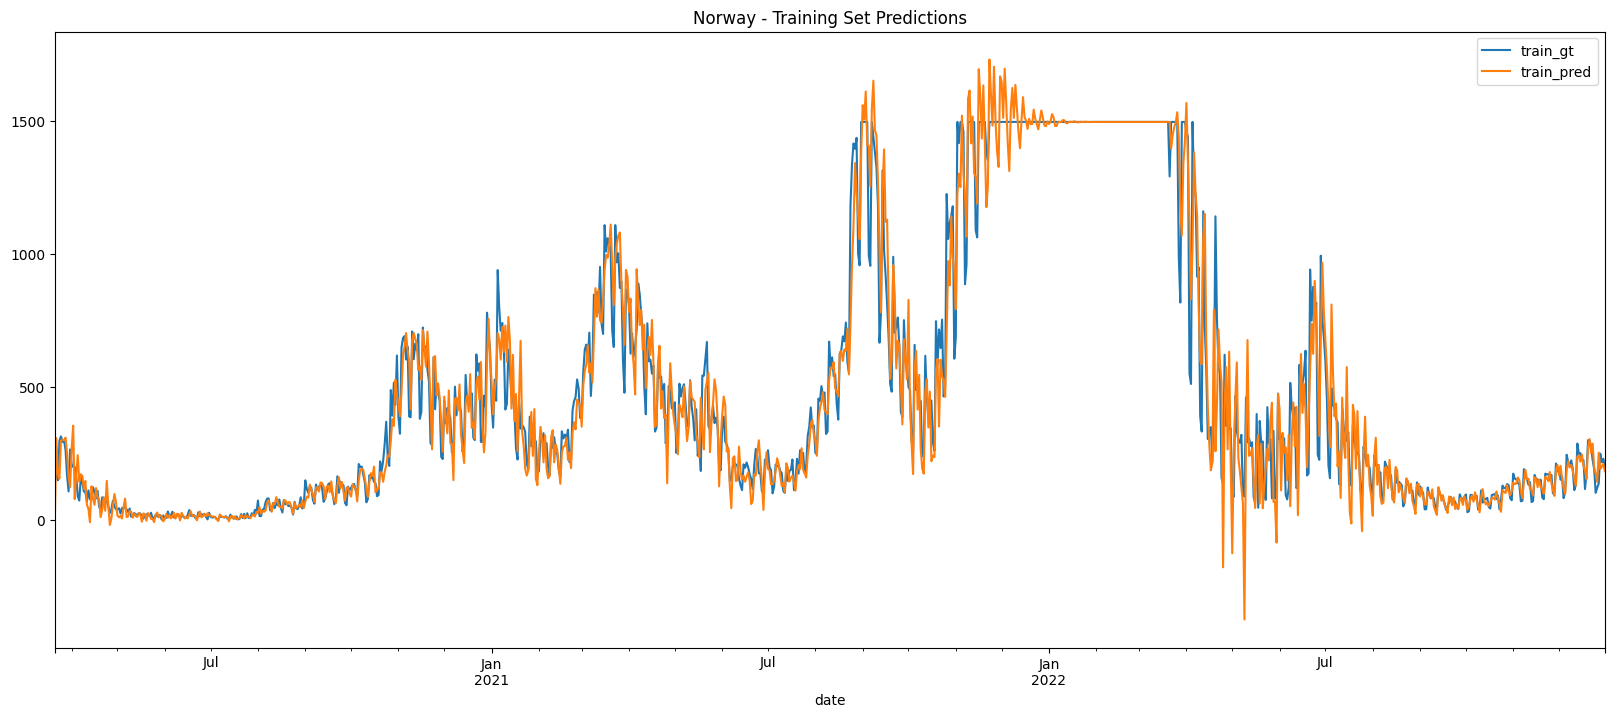

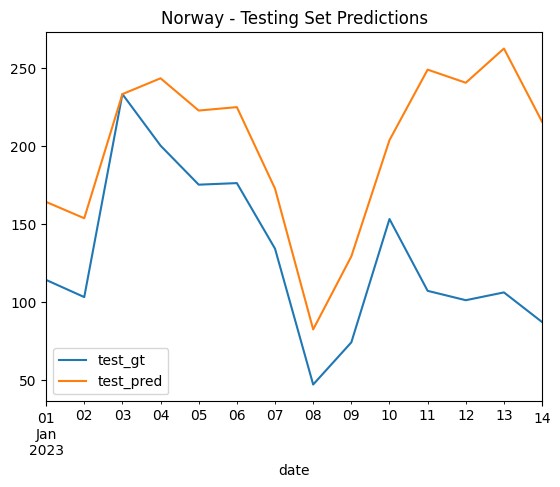

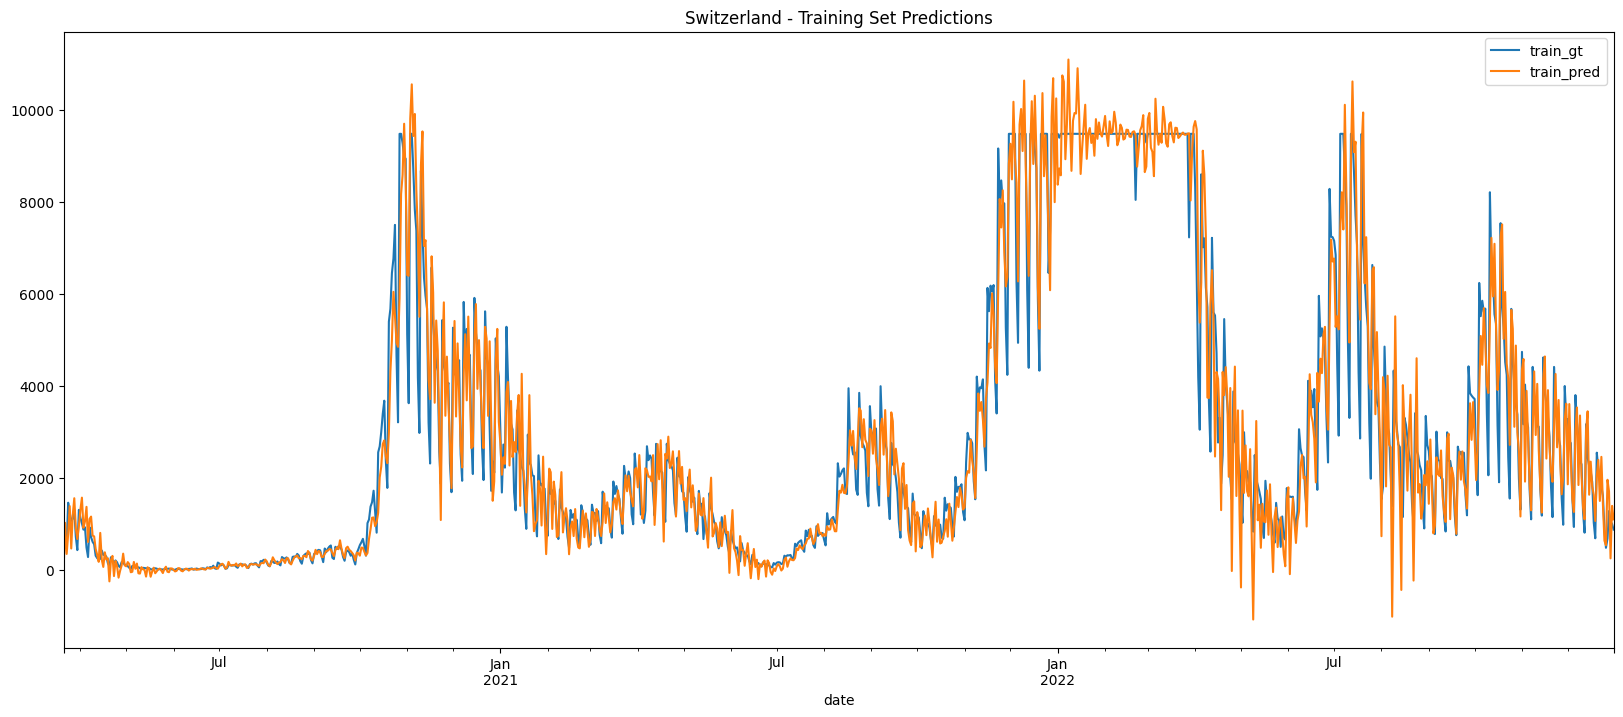

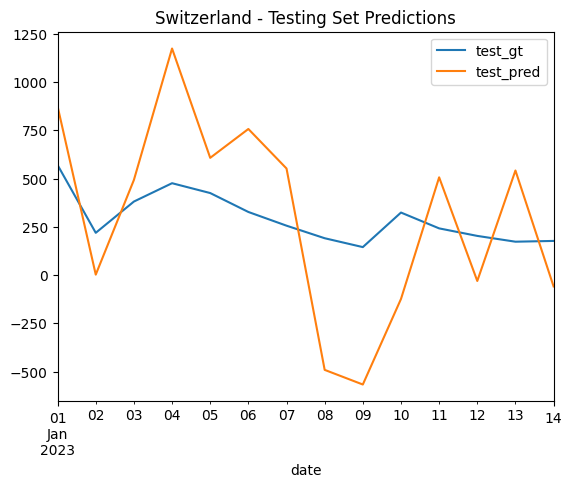

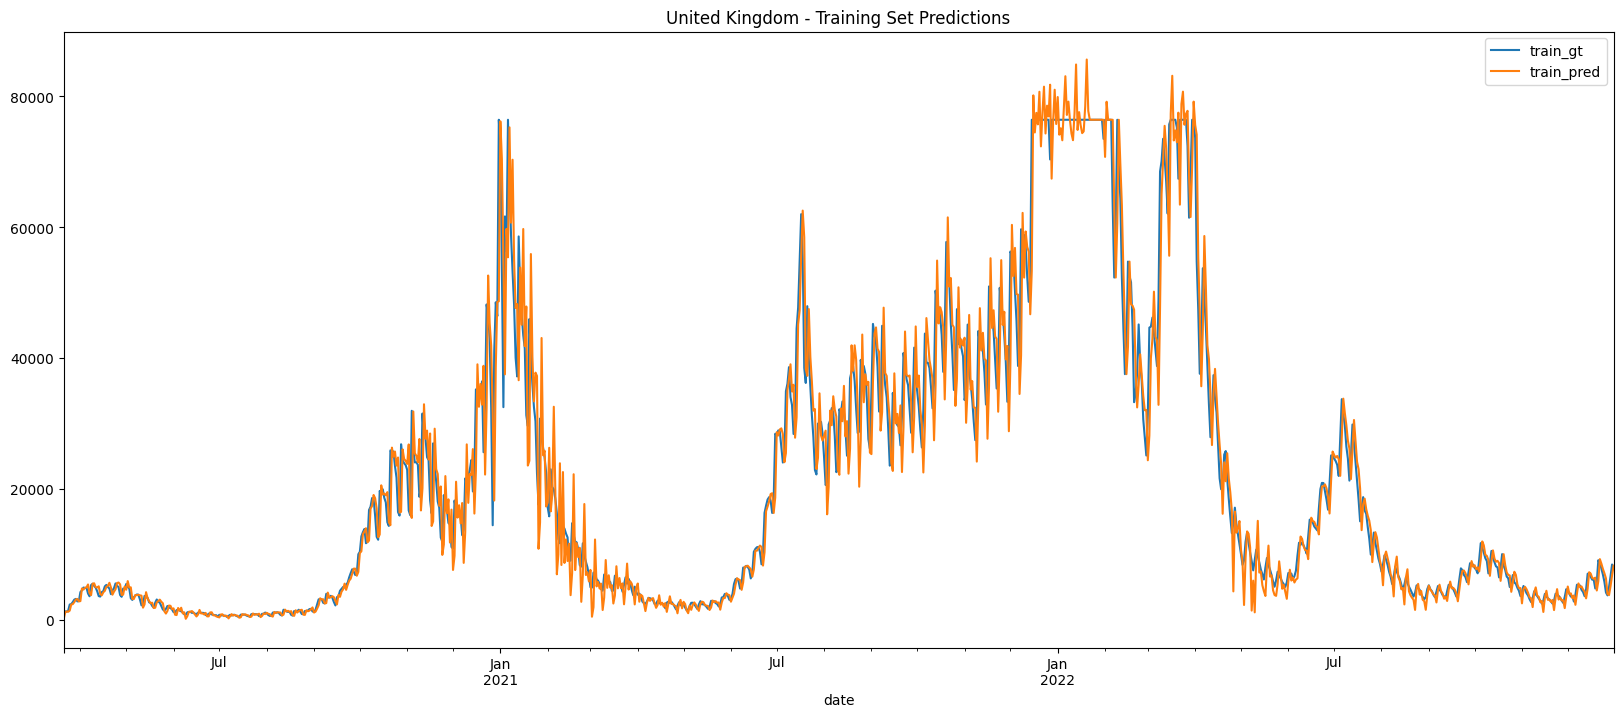

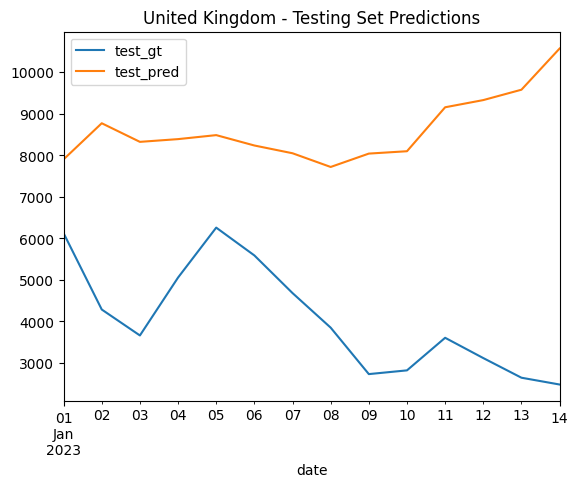

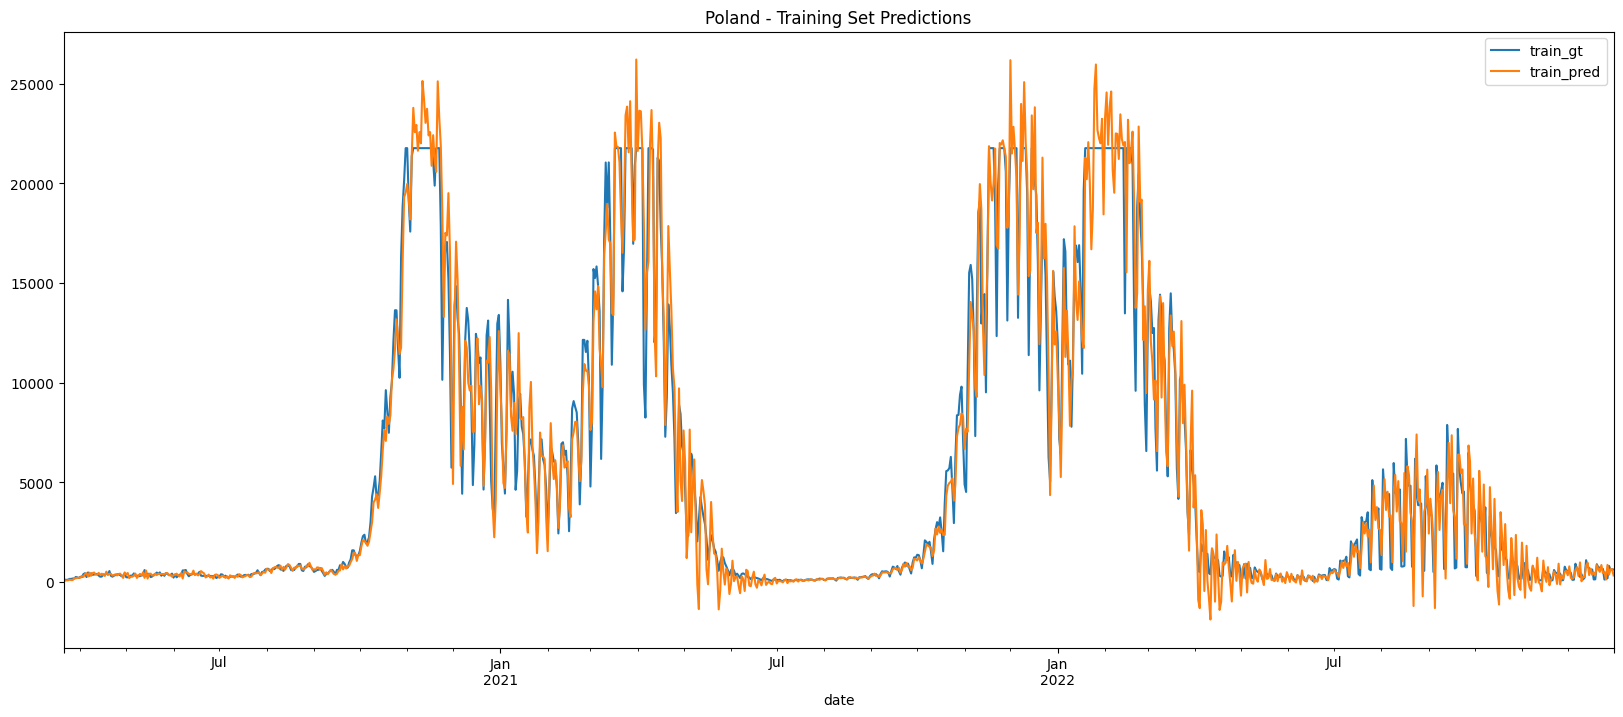

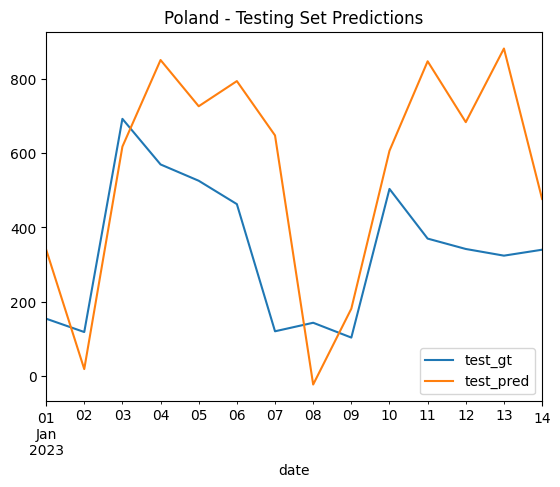

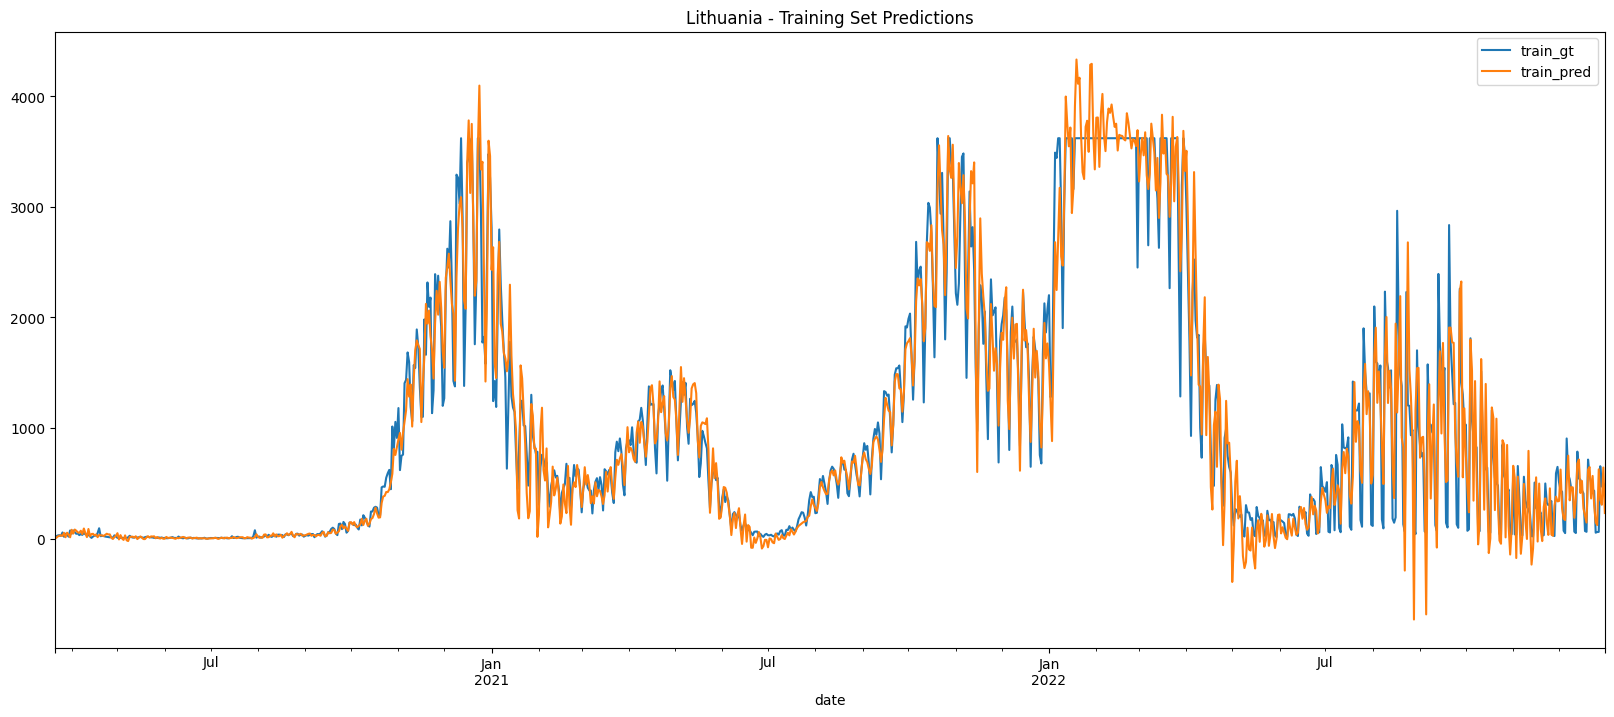

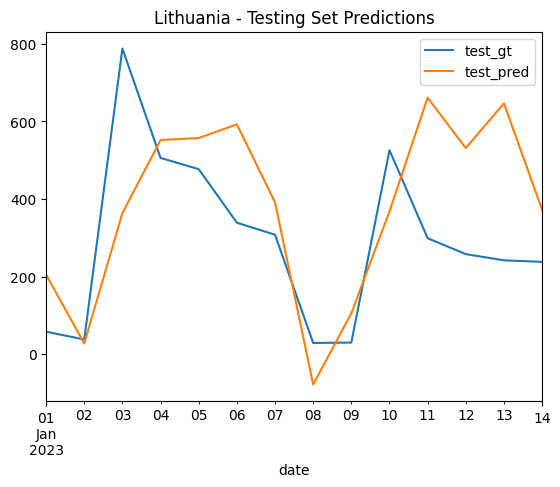

In [92]:
rmse_results = {}
country_list = ['Belgium', 'Denmark', 'Finland', 'Ireland', 'Italy', 'Norway', 'Switzerland', 'United Kingdom', 'Poland', 'Lithuania']

for country in country_list:
    train_country, test_country = get_country_data(country, train, test) 
    
    # Fit the Auto ARIMA model
    model_auto_country = auto_arima(train_country, start_p=1, start_q=1,
                                    max_p=5, max_q=5, m=12,
                                    start_P=0, seasonal=True,
                                    d=1, D=1, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)
    print(f'{country} - AIC: {model_auto_country.aic()}')

    # Make predictions on the training set
    train_pred = model_auto_country.predict_in_sample()
    pd.concat([train_country, pd.Series(train_pred, index=train_country.index)], axis=1).plot(figsize=(20, 8))
    plt.legend(['train_gt', 'train_pred'])
    plt.title(f'{country} - Training Set Predictions')

    # Make predictions on the testing set
    test_pred = model_auto_country.predict(n_periods=len(test_country))
    pd.concat([test_country, pd.Series(test_pred, index=test_country.index)], axis=1).plot()
    plt.legend(['test_gt', 'test_pred'])
    plt.title(f'{country} - Testing Set Predictions')

    # Calculate RMSE
    train_rmse = sqrt(mean_squared_error(train_country, train_pred))
    test_rmse = sqrt(mean_squared_error(test_country, test_pred))
    rmse_results[country] = {
        'train_rmse': train_rmse, 
        'test_rmse': test_rmse,
        'order': model_auto_country.order,
        'seasonal_order': model_auto_country.seasonal_order,
        'aic': model_auto_country.aic()
    }

    print(f'{country} - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}, Order: {model_auto_country.order}, Seasonal Order: {model_auto_country.seasonal_order}, AIC: {model_auto_country.aic()}')

# Convert RMSE and ARIMA parameter results to DataFrame
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)
